In [1]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from statsmodels import api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import Pool, CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.pipeline import Pipeline
import pickle
# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer
from time import time

%matplotlib inline
plt.rcParams['figure.figsize']=[15,8]

In [2]:
# reading the csv file and saving it as df

df = pd.read_csv('train_data.csv')
df.head(2)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50


# EDA

## Descriptive analysis

from pandas_profiling import ProfileReport
profile = ProfileReport(df,title='Detailed Dataset Report')
profile.to_notebook_iframe()

In [3]:

df_dict = pd.read_csv('train_data_dictionary.csv')
df_dict


,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [5]:
# The list of columns for
# 1) The type for which have to be converted
# 2) The columns that can be dropped based on what they represent

dtype_num_to_obj = ['Hospital_code', 'City_Code_Hospital', 'Bed Grade', 'City_Code_Patient']
can_drop = ['patientid', 'case_id']

## Duplicated values

In [6]:
df.shape

(318438, 18)

In [7]:
def del_duplicates(data):
    clean_data = data.drop_duplicates(keep='first')
    return clean_data

In [8]:
df = del_duplicates(df)

In [9]:
df.shape

(318438, 18)

## Missing Values

In [10]:
df['Bed Grade'].unique()

array([ 2.,  3.,  4.,  1., nan])

In [11]:
# dealing with the missing values before changing datatype of the columns

round(df.isnull().sum()/df.shape[0], 4)

case_id                              0.0000
Hospital_code                        0.0000
Hospital_type_code                   0.0000
City_Code_Hospital                   0.0000
Hospital_region_code                 0.0000
Available Extra Rooms in Hospital    0.0000
Department                           0.0000
Ward_Type                            0.0000
Ward_Facility_Code                   0.0000
Bed Grade                            0.0004
patientid                            0.0000
City_Code_Patient                    0.0142
Type of Admission                    0.0000
Severity of Illness                  0.0000
Visitors with Patient                0.0000
Age                                  0.0000
Admission_Deposit                    0.0000
Stay                                 0.0000
dtype: float64

In [12]:
# As we can see that the number of missing values in our dataset are very low, we can just go ahead and remove those records
# Then we reset the index.

df.dropna(inplace = True)

df.reset_index(drop = True, inplace = True)

In [13]:
# Now we change the datatypes of the columns

df[dtype_num_to_obj] = df[dtype_num_to_obj].astype('object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313793 entries, 0 to 313792
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            313793 non-null  int64  
 1   Hospital_code                      313793 non-null  object 
 2   Hospital_type_code                 313793 non-null  object 
 3   City_Code_Hospital                 313793 non-null  object 
 4   Hospital_region_code               313793 non-null  object 
 5   Available Extra Rooms in Hospital  313793 non-null  int64  
 6   Department                         313793 non-null  object 
 7   Ward_Type                          313793 non-null  object 
 8   Ward_Facility_Code                 313793 non-null  object 
 9   Bed Grade                          313793 non-null  object 
 10  patientid                          313793 non-null  int64  
 11  City_Code_Patient                  3137

In [15]:
df.shape

(313793, 18)

In [16]:
df_num = df.select_dtypes(np.number)
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313793 entries, 0 to 313792
Data columns (total 5 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            313793 non-null  int64  
 1   Available Extra Rooms in Hospital  313793 non-null  int64  
 2   patientid                          313793 non-null  int64  
 3   Visitors with Patient              313793 non-null  int64  
 4   Admission_Deposit                  313793 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 12.0 MB


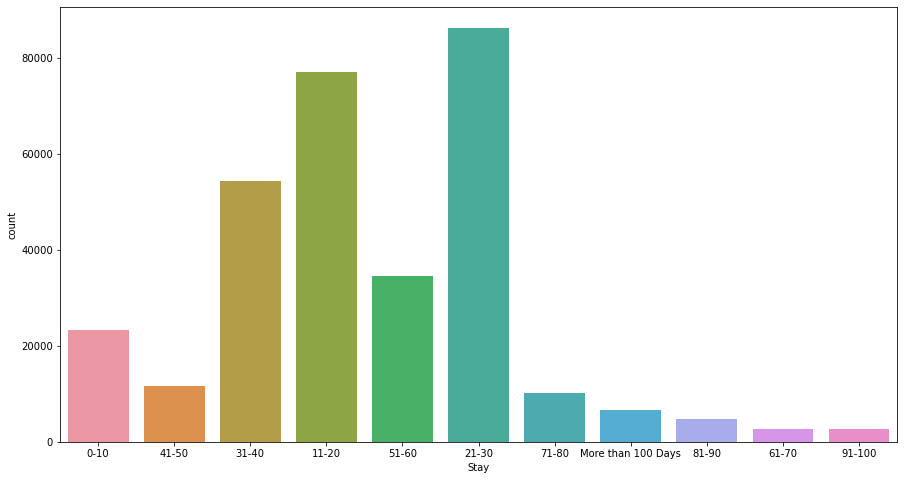

In [17]:
sns.countplot(df.Stay);

In [18]:
df['Stay']= df['Stay'].replace({'0-10':'<20', '11-20':'<20', '21-30':'21-30', '31-40':'31-40', '41-50':'>40', '51-60':'>40','61-70':'>40','71-80':'>40','81-90':'>40','91-100':'>40','More than 100 Days':'>40'})

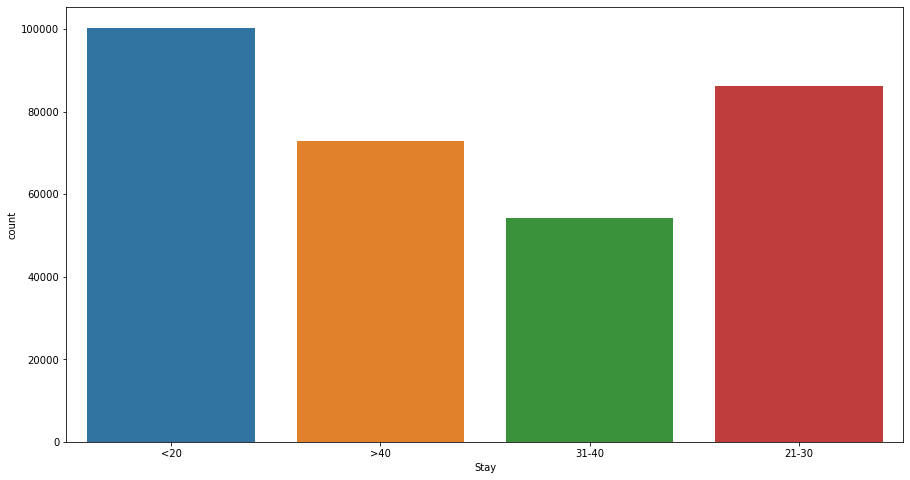

In [19]:
sns.countplot(df.Stay);

## Outlier Analysis

Skewness: 0.003730515399384672


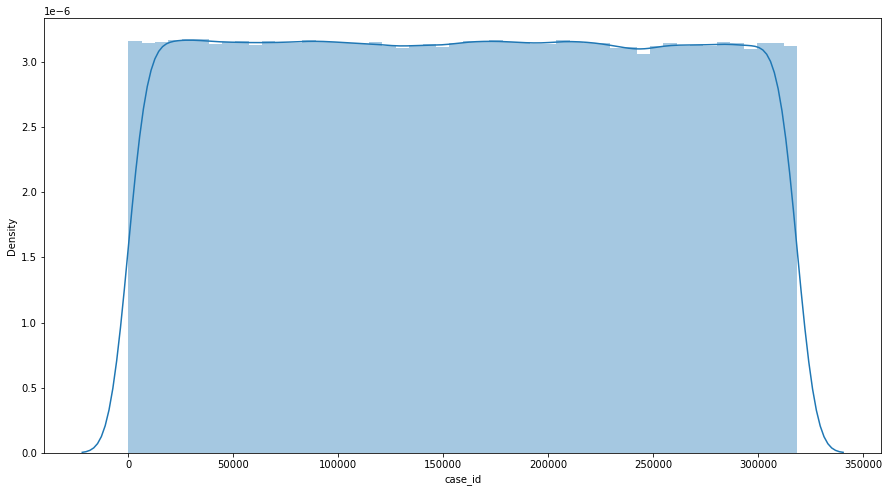



Skewness: 0.9755183071110464


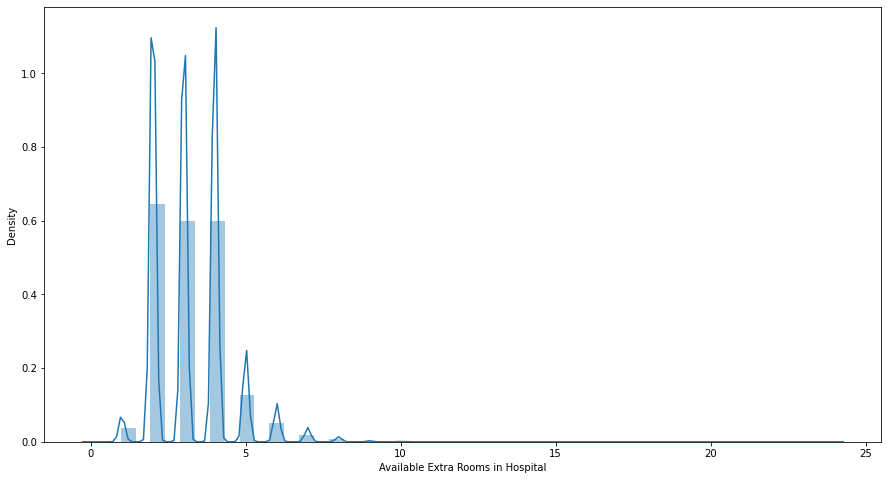



Skewness: 0.0020908949315743297


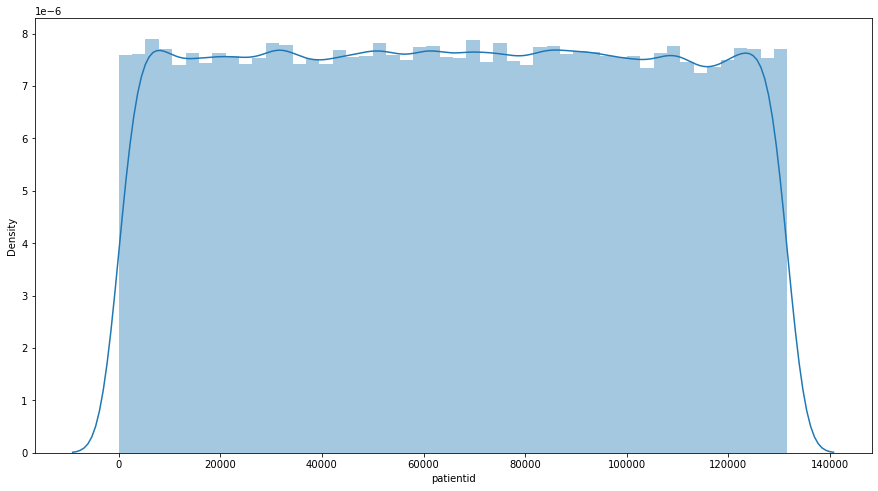



Skewness: 3.1479686794019996


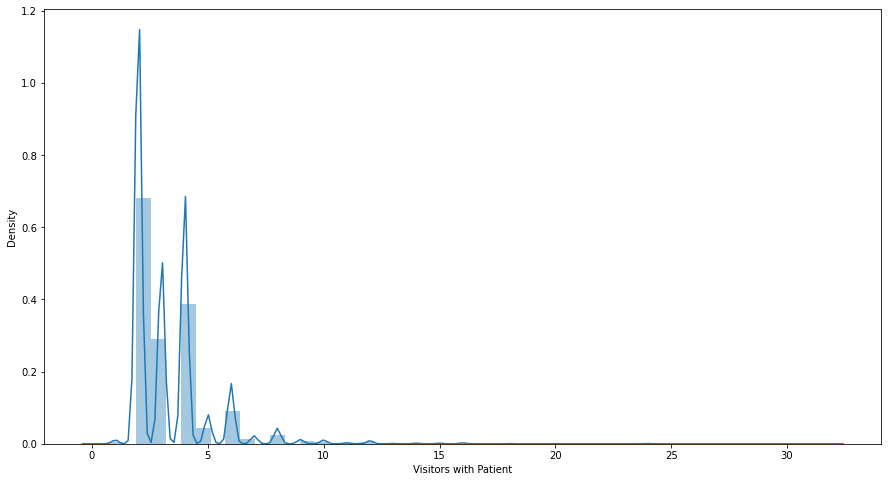



Skewness: 0.9307755404140482


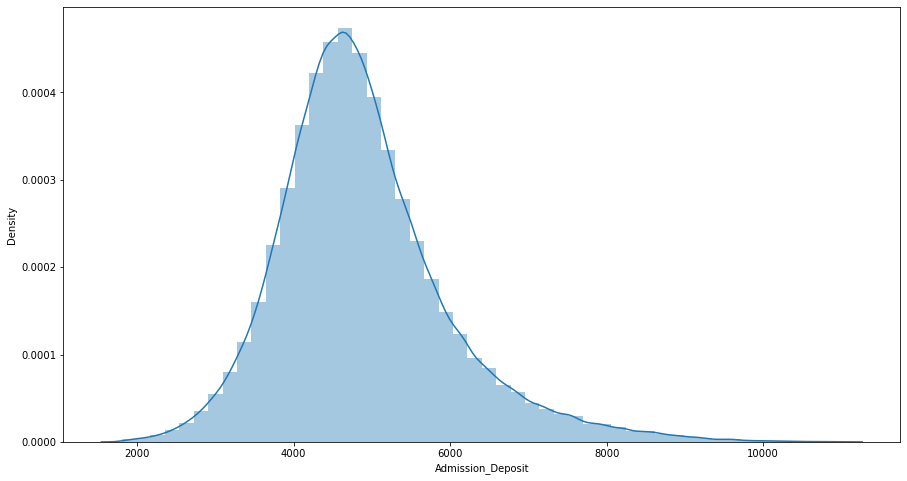

In [20]:
for i in df_num.columns:
    sns.distplot(df_num[i])
    print('Skewness:', df_num[i].skew())
    plt.show()
    print('\n')

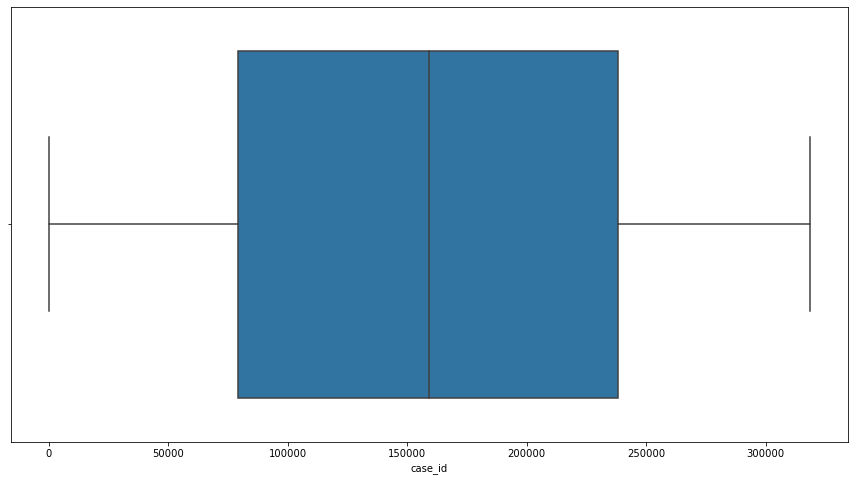

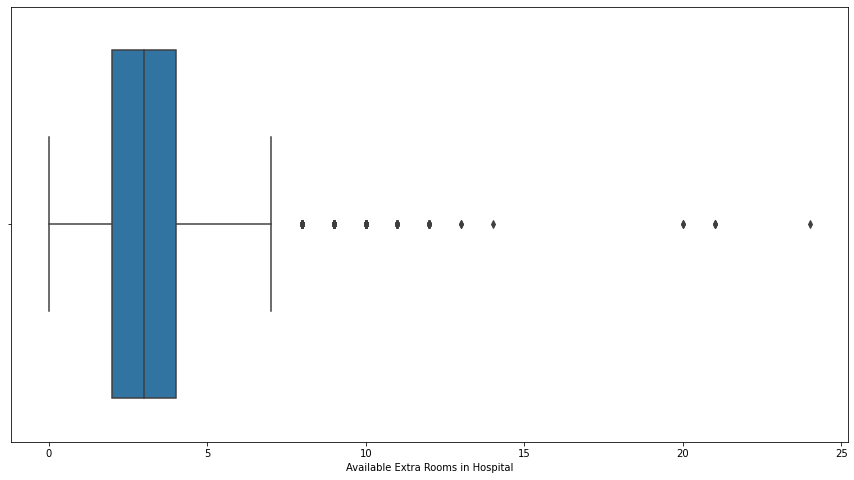

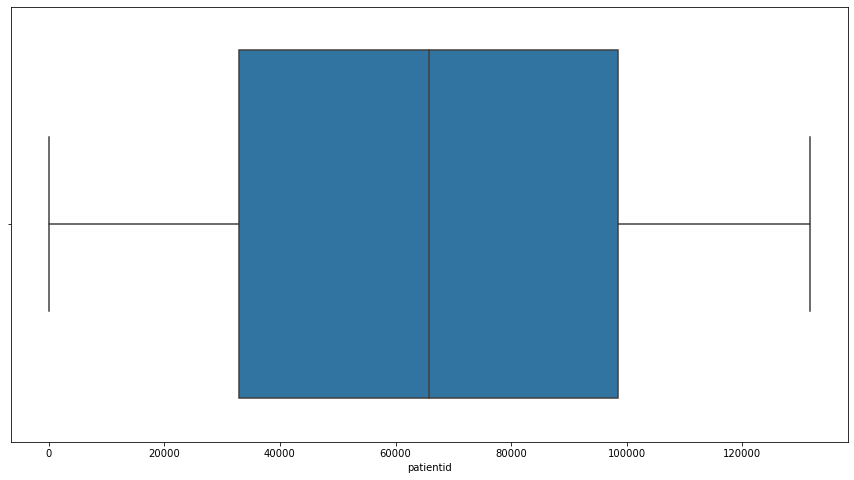

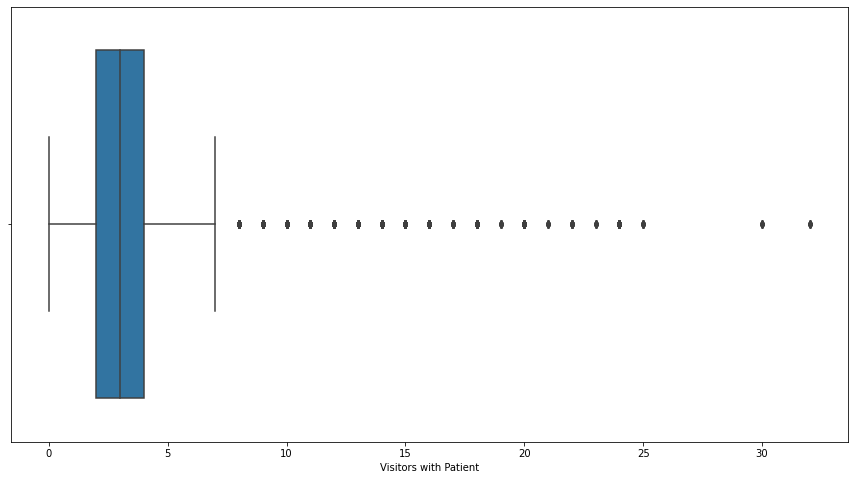

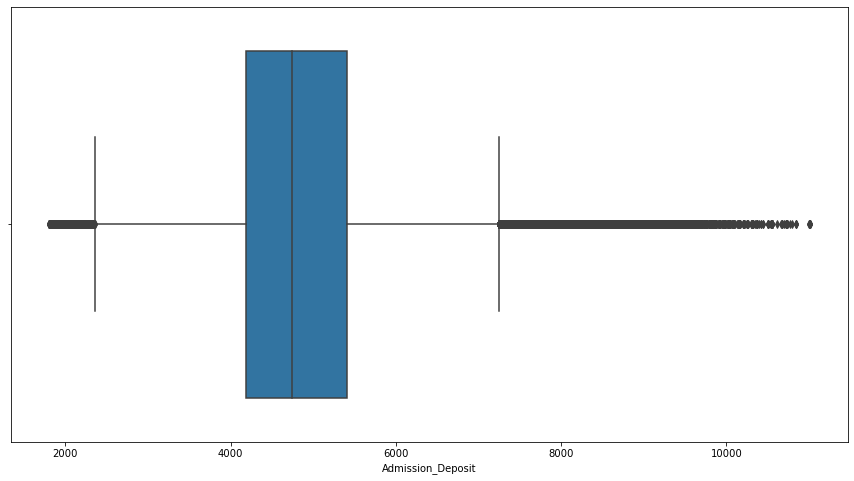

In [21]:
# To check for outliers

for i in df_num.columns:
    sns.boxplot(df_num[i])
    plt.show()

In [22]:
# This feature has a lot of discrete values, so we can convert it into a categorical feature.
# Below is given the explanation for how many categories we choose to include in the data.

df_num['Visitors with Patient'].value_counts()

2     136680
4      78044
3      58259
6      18510
5       9028
8       4775
7       2453
9       1331
1       1189
10      1168
12       949
11       318
16       281
14       202
15       187
13       102
24        78
18        60
20        59
17        20
22        19
0         18
19        12
25        12
21        11
23        10
30         9
32         9
Name: Visitors with Patient, dtype: int64

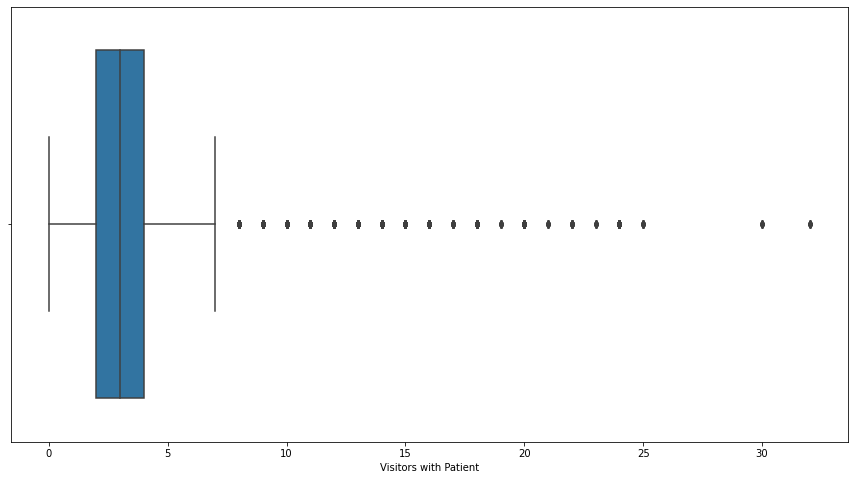

In [23]:
sns.boxplot(df_num['Visitors with Patient']);

## Feature Engineering

In [24]:
# The average visiting hours for patients is around 3 hours in a hospital. (Checked the websites of a few renowned hospitals.)
# Checked for Apollo, AIIMS, Lilavati.

# According to a paper by US national library of Medicine (Couldn't find any paper refering to indian hospitals),
# the median visitors for a patient per hour is 3.5, out of which personal visitors make around 23% of those visitors.

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3531228/

# So, (23/100)      *    3.5    *       3
#      % of            median no.     hours open
# personal visitors   of visitors     personal visitors

# ~ 2.5

# This are very vague assumptions, but gives us a base to convert it to a range.

In [25]:
print(df_num['Visitors with Patient'][df_num['Visitors with Patient'] > 3].value_counts().sum())

print(df_num['Visitors with Patient'][df_num['Visitors with Patient'] <= 3].value_counts().sum())

117647
196146


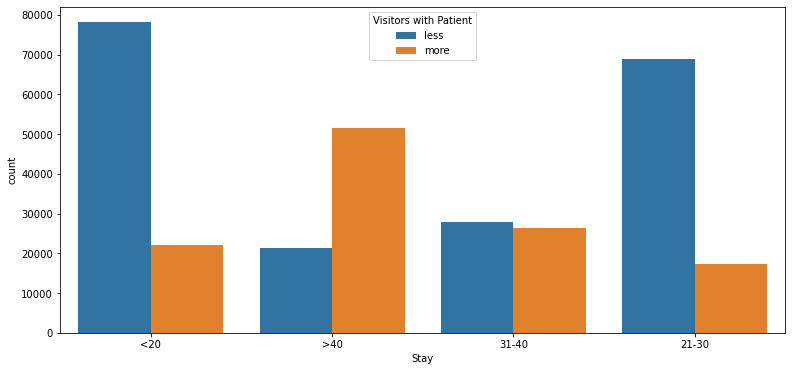

In [26]:
def visitors_converter(x):
    if x > 3:
        return 'more'
    else:
        return 'less'

df['Visitors with Patient'] = df_num['Visitors with Patient'].map(visitors_converter)

plt.rcParams['figure.figsize'] = [13, 6]
sns.countplot(df.Stay, hue = df['Visitors with Patient'])
plt.show()

In [27]:
df_num.drop('Visitors with Patient', axis = 1, inplace = True)

In [28]:
print(df.patientid.nunique())
print("Here we can see that not all patient id's are unique.")

90344
Here we can see that not all patient id's are unique.


In [29]:
# So we make a new column that can store how many times the patient has already been admitted according to our data
# This is to prevent any data loss when we remove the column patient id

# Firstly, we check for null values in patient id

df.patientid.isnull().sum()

0

In [30]:
df.groupby(by=['City_Code_Hospital']).nunique()['Hospital_code']

City_Code_Hospital
1     6
2     3
3     6
4     3
5     4
6     2
7     2
9     3
10    1
11    1
13    1
Name: Hospital_code, dtype: int64

In [31]:
# As this column has no null values we proceed further
# We store the number of times a unique patient id in the records in a dictionary
# Then make a new column that stores it for each corresponding values of the patientid

patientid_dict = dict(df.patientid.value_counts())

No_Hospitals_in_city_dict = df.groupby(by=['City_Code_Hospital']).nunique()['Hospital_code']
No_City_in_region_dict = df.groupby(by=['Hospital_region_code']).nunique()['City_Code_Hospital']
no_of_wards_dict = pd.crosstab(df.Hospital_code, df.Ward_Type).astype(bool).sum(axis = 1)

In [32]:
df['No of times patient appears in data'] = df.patientid.map(patientid_dict)

In [33]:
df['No_Hospitals_in_city'] = df['City_Code_Hospital'].map(No_Hospitals_in_city_dict)

In [34]:
df['No_City_in_region'] = df['Hospital_region_code'].map(No_City_in_region_dict)

In [35]:
df['no_of_wards'] = df['Hospital_code'].map(no_of_wards_dict)

In [36]:
# Dropping the insiginificant Columns

df.drop(labels = can_drop, axis = 1, inplace = True)

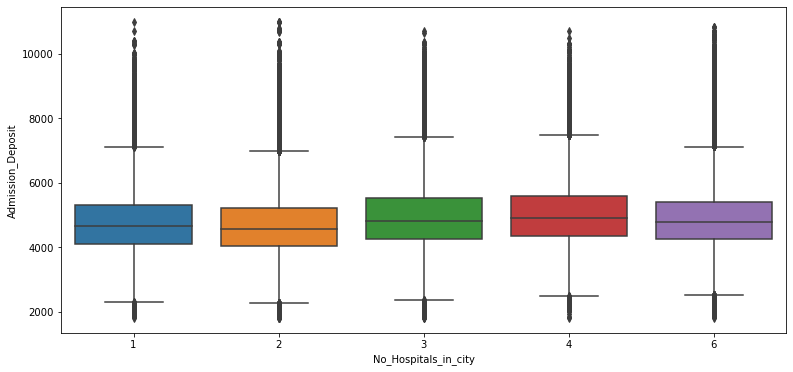

In [37]:
sns.boxplot(df['No_Hospitals_in_city'], df['Admission_Deposit']);

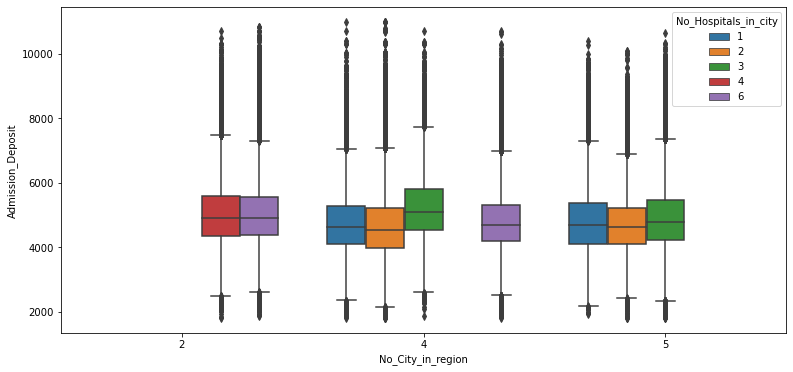

In [38]:
sns.boxplot(df['No_City_in_region'], df['Admission_Deposit'], hue=df['No_Hospitals_in_city']);

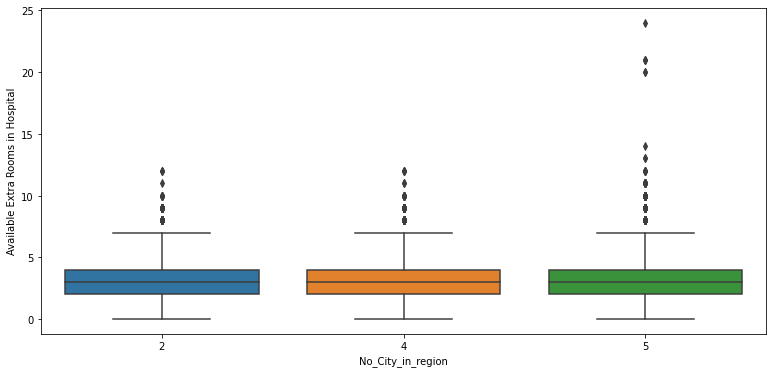

In [39]:
sns.boxplot(df['No_City_in_region'], df['Available Extra Rooms in Hospital']);

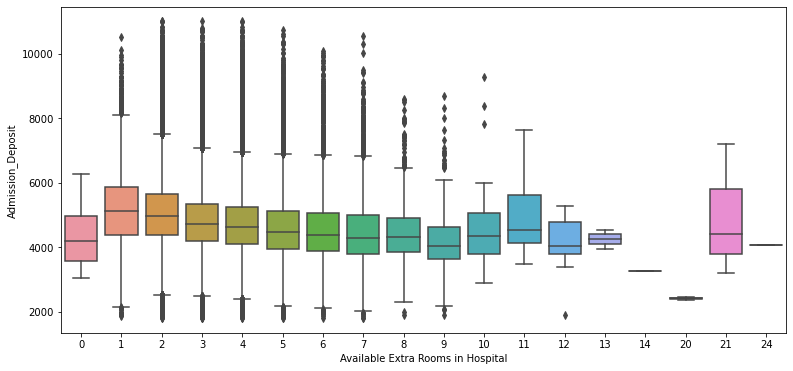

In [40]:
sns.boxplot(df['Available Extra Rooms in Hospital'], df.Admission_Deposit);

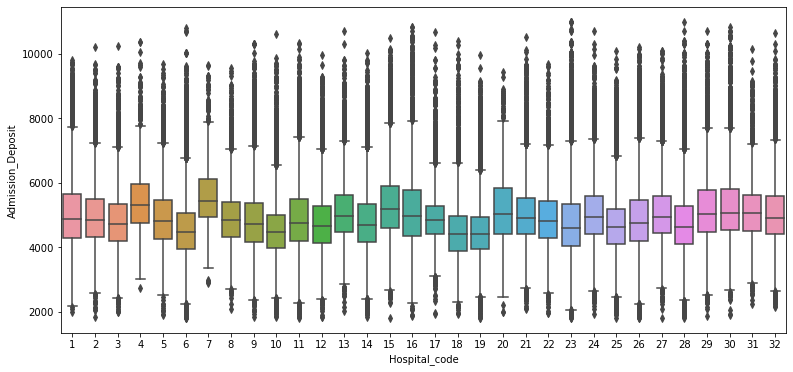

In [41]:
# Average admission fees for each hospital
# Shows how expensive the hospital is

sns.boxplot(df.Hospital_code, df.Admission_Deposit);

In [42]:
# All the hospitals have a median value of admission deposit between 4000 and 6000

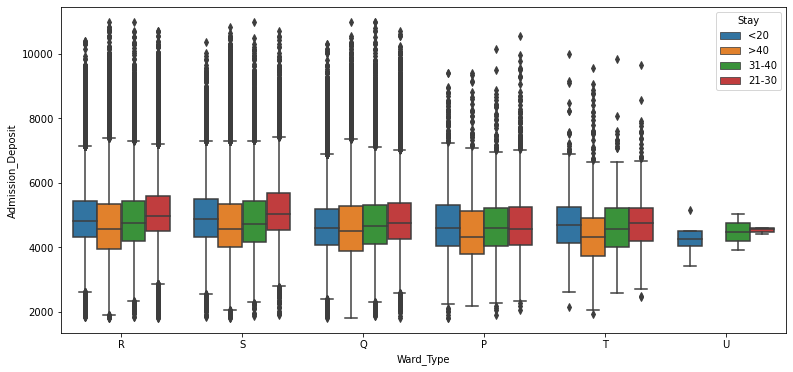

In [43]:
sns.boxplot(df['Ward_Type'], df.Admission_Deposit, hue=df.Stay);

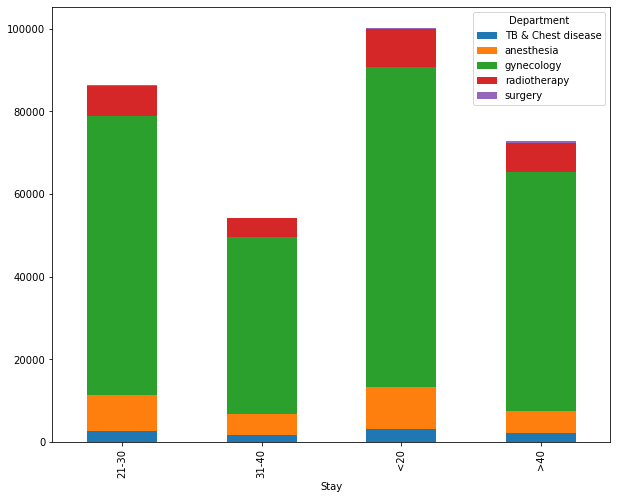

In [44]:
x = pd.crosstab(df.Department, df.Stay)
x.T.plot(kind = 'bar', stacked = True, figsize = (10,8))
plt.show()

In [45]:
# We can see that Gyneacology has the most number of patients. Also most of the patients are required to stay around 0-40 days.

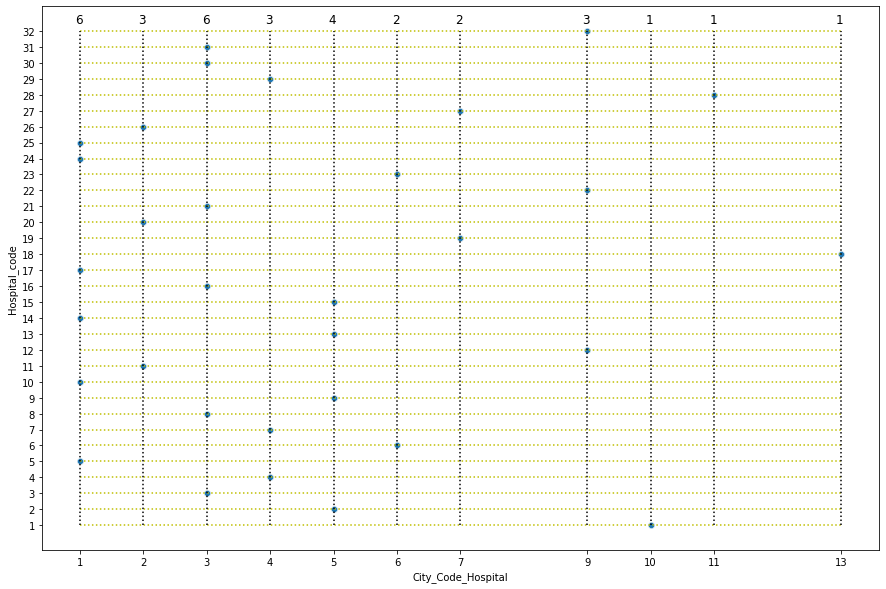

In [46]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.scatterplot(df.City_Code_Hospital.astype('int32'), df.Hospital_code.astype('int32'))
plt.xticks(sorted(df.City_Code_Hospital.astype('int32').unique()), [1,2,3,4,5,6,7,9,10,11,13])
plt.yticks(sorted(df.Hospital_code.astype('int32').unique()), list(range(1, 33)))

plt.hlines(list(range(1, 33)), xmin = 1, xmax = 13, linestyles = 'dotted', color = 'y')

plt.vlines([1,2,3,4,5,6,7,9,10,11,13], ymin = 1, ymax = 32, colors = 'k', linestyles = 'dotted')

lst = [6, 3, 6, 3, 4, 2, 2, '', 3, 1, 1, '', 1]
for i in range(0, 13):
    plt.text(x = (i + 0.925), y = 32.5, s = lst[i], fontsize = 12)

plt.show()

In [47]:
# We can see the number of hospitals in each city.
# The dots on the black lines are the one's that are in the same city

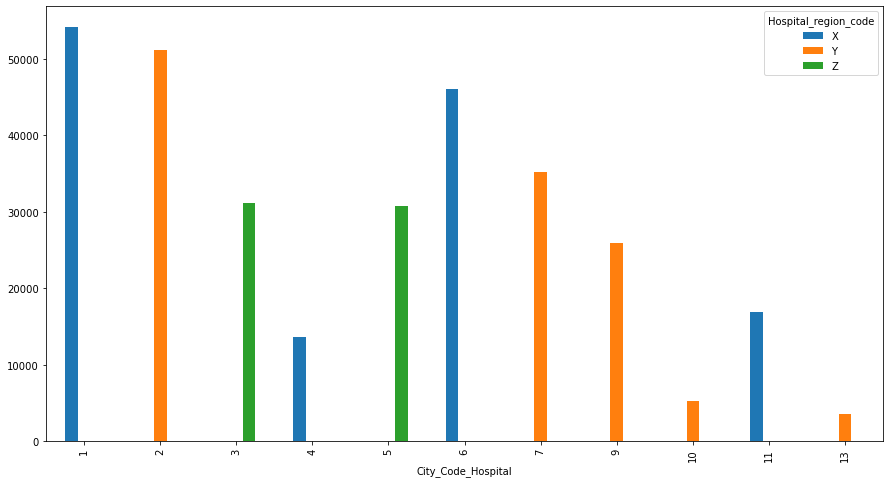

In [48]:
pd.crosstab(df['City_Code_Hospital'],df['Hospital_region_code']).plot(kind='bar',figsize=(15,8))
plt.show()

In [49]:
# Here we can see that Cities 1, 4, 6 and 11 have the same region code. So we can say that these regions are mostly the states.

In [50]:
# We proceed to look into the column Hospital_code.
# Mainly because it has 32 different hospitals, which is too many categories

df.Hospital_code.nunique()

32

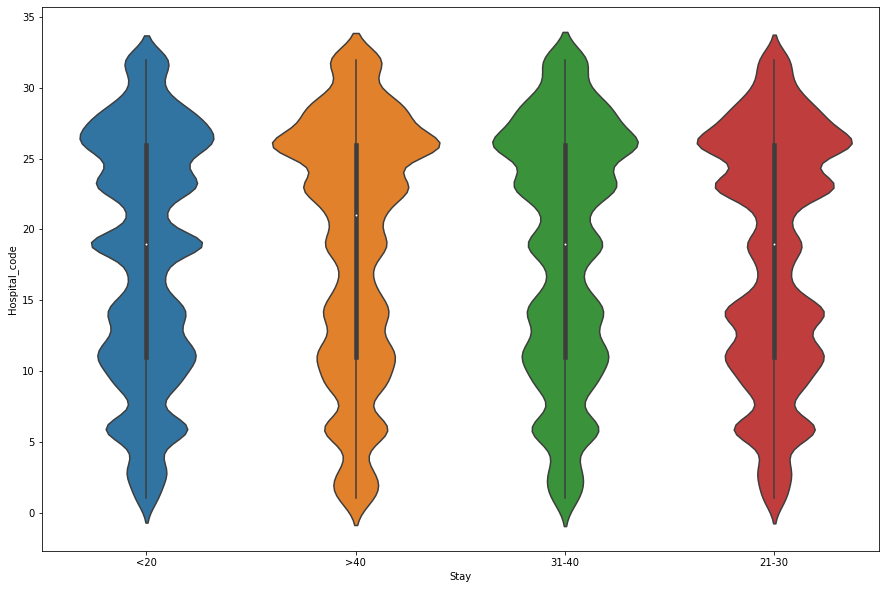

In [51]:
sns.violinplot(df.Stay, df.Hospital_code.astype('int'));

In [52]:
# Here we dont see any such pattern by which we can differentiate the hospitals
# Even the overall ditribution is pretty similar.
# Insight - So one can say these are all multi-speciality hospitals
# So we can proceed to drop this column

columns_drop_FE = ['Hospital_code']

In [53]:
# This shows that each hospital has a unique ward facility code. i.e. No hospital has two ward facility codes.
# Now we can be certain that we can eliminate the column Hospital code

pd.crosstab(df.Hospital_code, df.Ward_Facility_Code).astype(bool).sum(axis = 1)

Hospital_code
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
dtype: int64

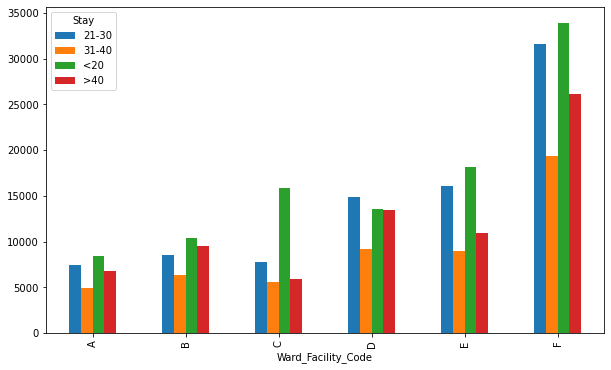

In [54]:
pd.crosstab(df.Ward_Facility_Code, df.Stay).plot.bar(figsize = (10,6));

# There is no specific insight from this graph. But we can say that all the wards get different number patients.
# I suspect that these wards have higher number of hospitals included in them.
# We will further look into it.

In [55]:
pd.crosstab(df.Hospital_code, df.Ward_Facility_Code).astype(bool).sum()

Ward_Facility_Code
A     5
B     5
C     2
D     3
E     6
F    11
dtype: int64

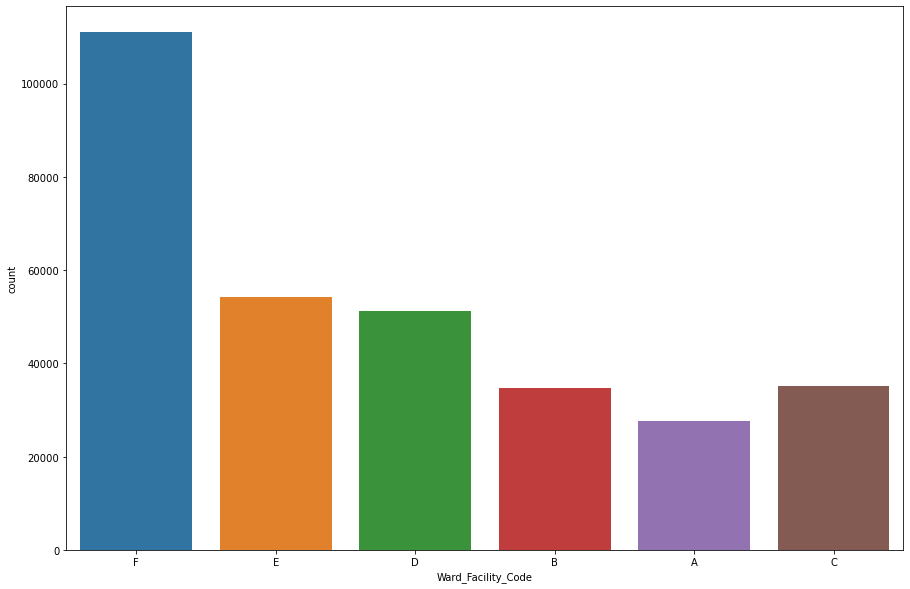

In [56]:
sns.countplot(df.Ward_Facility_Code);

In [57]:
# We can take the counts for each ward and divide them by the number of hospitals in each ward to
## get an exact idea of which ward has more admissions
# We can also further check if the admission fees for such wards is more
# And can also check if the number of empty rooms is lesser

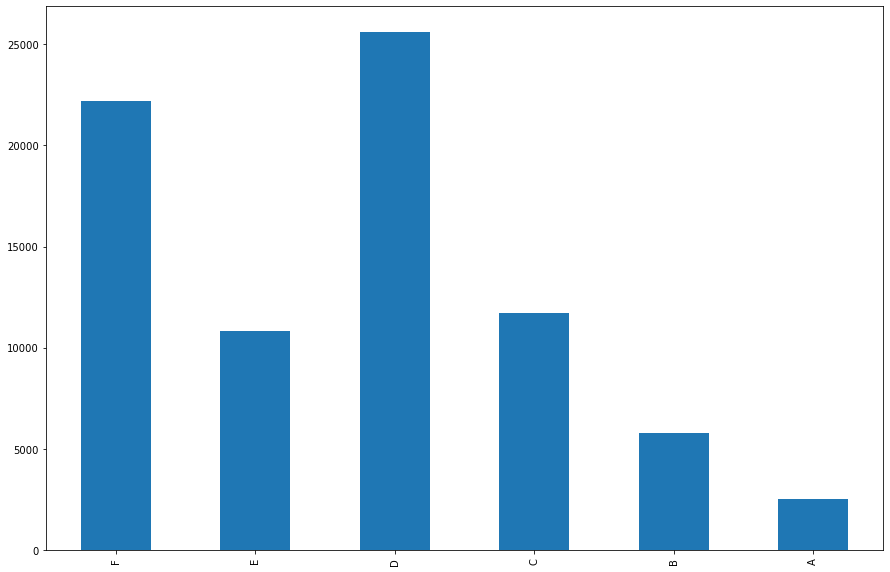

In [58]:
x = df.Ward_Facility_Code.value_counts()//(pd.crosstab(df.Hospital_code, df.Ward_Facility_Code).astype(bool).sum().values)

x.plot.bar();

In [59]:
# From the above graph we can say that the facility D has the most patients per hospital

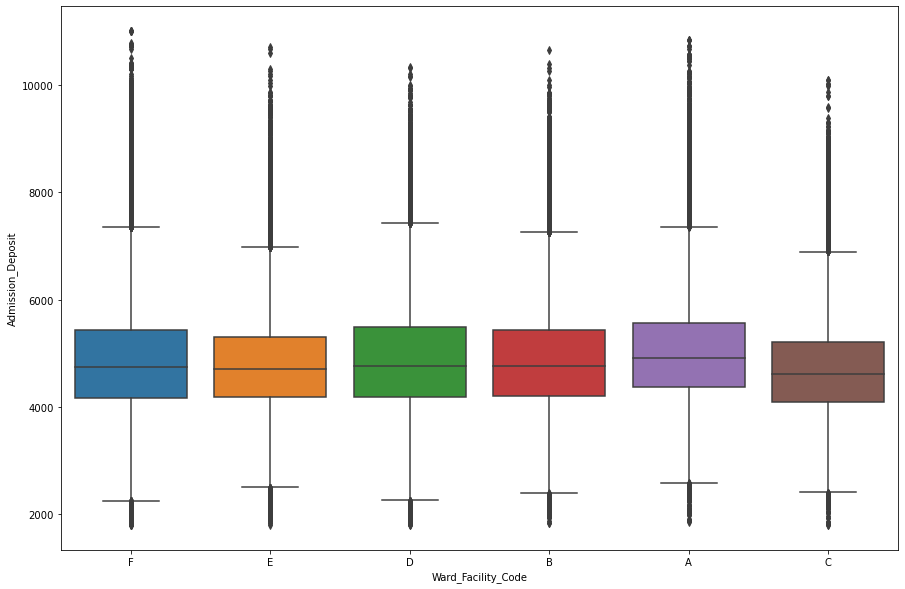

In [60]:
sns.boxplot(df.Ward_Facility_Code, df.Admission_Deposit);

In [61]:
# Looking at the admission deposits for each ward we see no significant difference.
# Except for the Ward type C, where we know that only 2 hospitals have these types of ward.
## We can see that the median admission deposit is also lower for it.
## Even though this type of facility is rare, we still see a lower admission deposit.

# So we can conclude that even though the number of patients per hospital is high for a ward
## the admission deposit remains the same.

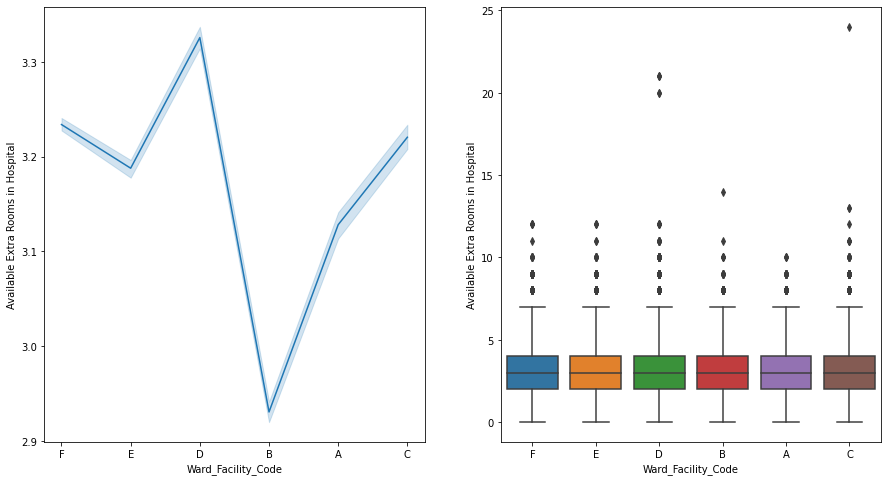

In [62]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize = (15,8))

sns.lineplot(df.Ward_Facility_Code, df['Available Extra Rooms in Hospital'], ax = ax1)

sns.boxplot(df.Ward_Facility_Code, df['Available Extra Rooms in Hospital'], ax = ax2)

plt.show()

In [63]:
# From the above lineplot we can see that the average number of extra rooms in each ward facility is between 2 and 3.
# Also we can see the mdeian value also is around 3 from the boxplot.

# So, as we wanted to check if the wards D and F would have a different number of available extra rooms
## now based on the above two observations we can say that it is incorrect.

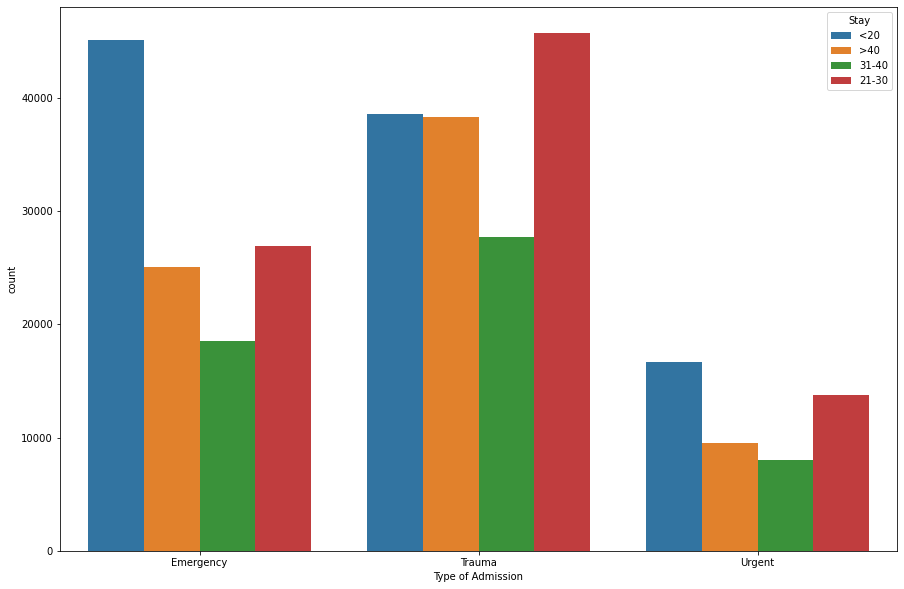

In [64]:
# Now looking into Types of admission
# Emergency: Emergency is when people are taken to the ER, an ER is equipped to deal with any kind of emergency.
# Trauma: Trauma is when the survival of the patient is in question
# Urgent: Urgent is basically a case where the issue is to be dealt with today, but it's not life threatening.

sns.countplot(df['Type of Admission'], hue = df.Stay);

In [65]:
# One thing that is clear from the above graph is that for any kind of admission,
# most patients are discharged in less than 30 days.

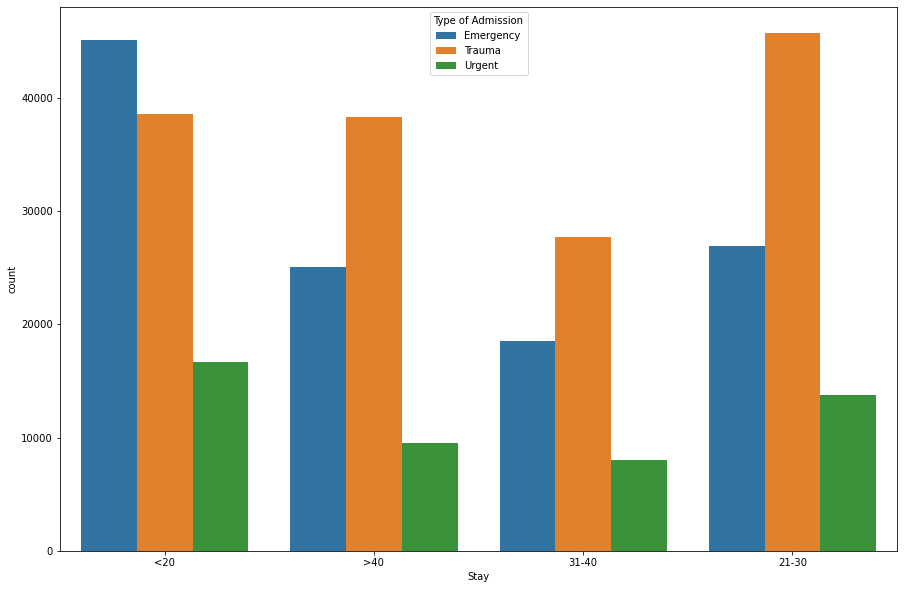

In [66]:
sns.countplot(df.Stay, hue = df['Type of Admission']);

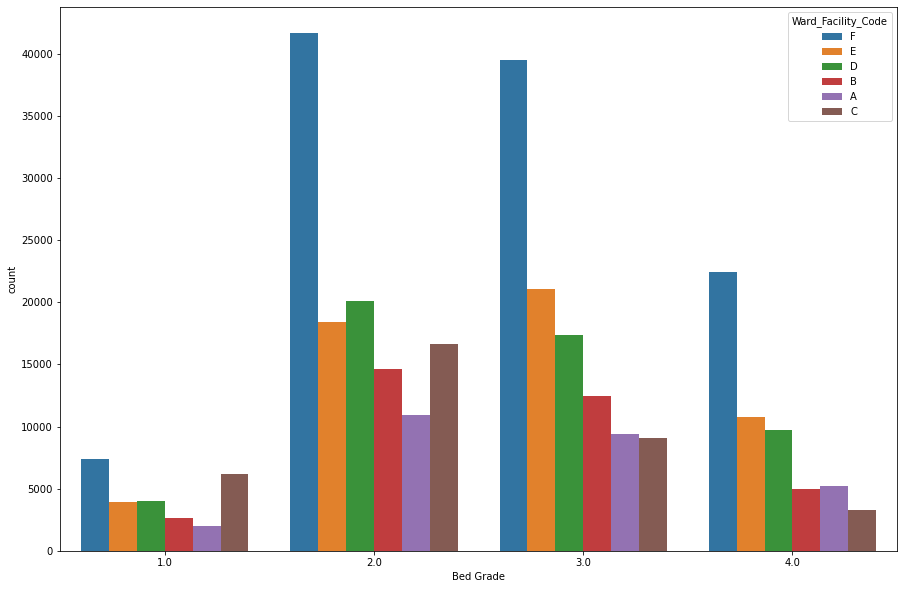

In [67]:
sns.countplot(df['Bed Grade'], hue = df.Ward_Facility_Code);

In [68]:
# There is not much difference when we look at the bed grade among different ward facilities
# The bed grades 2 and 3 are the most common one's
# Also it makes sense that bed grade 1 are very few,
## Because there will always be a strict check on the quality of service provided by the hospitals.

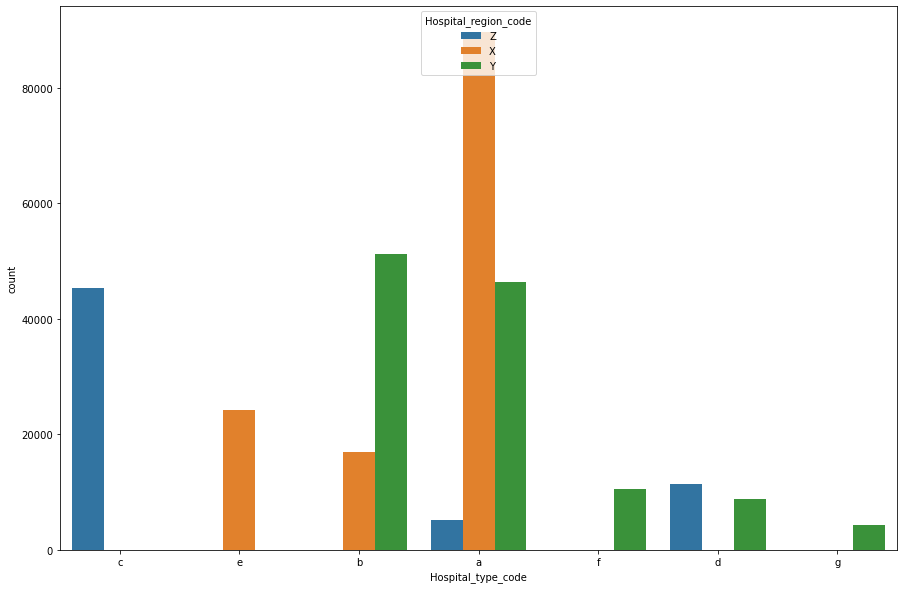

In [69]:
sns.countplot(df.Hospital_type_code, hue = df.Hospital_region_code);

In [70]:
# The graph shows no there is not much relation between the two columns

In [71]:
# Now we proceed to outlier removal and unnecessary column removal.

In [72]:
df.drop(['Hospital_code'], axis = 1, inplace = True)

In [73]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)

IQR = q3 - q1 

df = df[~((df < (q1 - 3 * IQR)) | (df > (q3 + 3 * IQR))).any(axis = 1)]

In [74]:
df.shape

(311657, 19)

In [75]:
df_num = df.select_dtypes(np.number)

# Assumptions

### No or Little Multicollinearity

#### Correlation Matrix

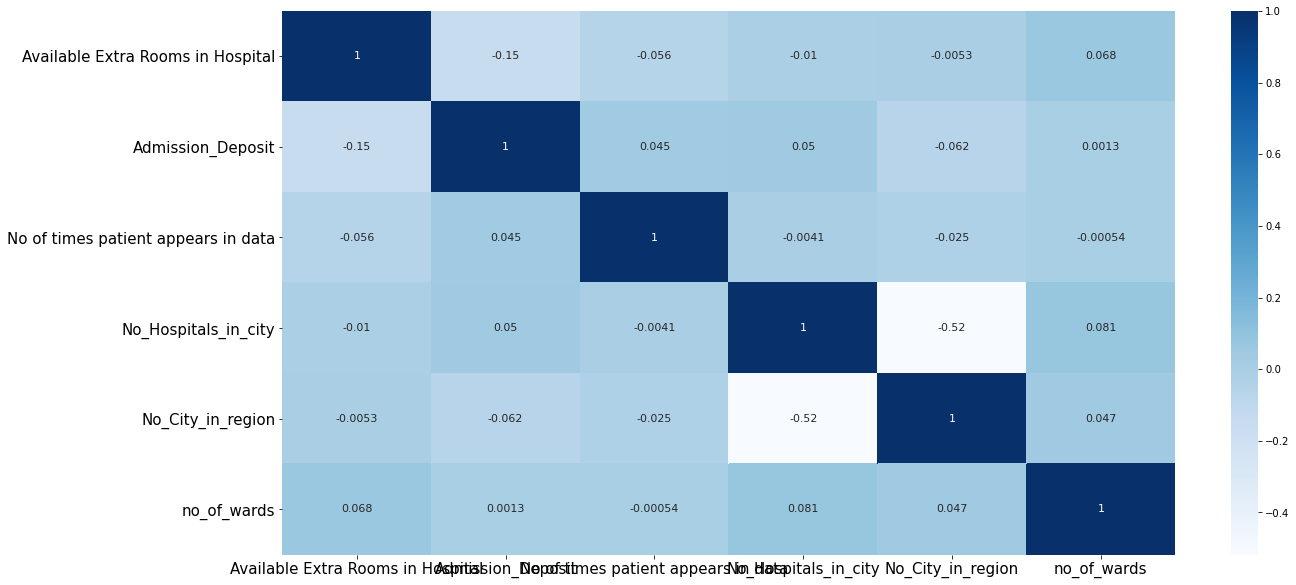

In [76]:
# set the plot size using figure()
# pass width and height in inches to 'figsize' 
plt.figure(figsize = (20,10))

# plot the heat map
# corr(): give the correlation matrix
# annot: prints the correlation values in the chart
# annot_kws: used to set the font size of the annotation
sns.heatmap(df_num.corr(), annot = True, annot_kws = {"size": 11}, cmap = 'Blues')

# rotation = 'horizontal' rotates the y-axis labels horizontally
# set text size using 'fontsize'
plt.yticks(rotation = 'horizontal', fontsize = 15)
plt.xticks(fontsize = 15)

# display the plot
plt.show()

In [77]:
# No correlation was found among the numerical features. So we can say no multicollinearity.

#### Variance Inflation Factor (VIF)

In [78]:
# create an empty dataframe to store the VIF for each variable
vif = pd.DataFrame()

# calculate VIF using list comprehension 
# use for loop to access each variable 
# calculate VIF for each variable and create a column 'VIF_Factor' to store the values 
vif["VIF_Factor"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]

# create a column of variable names
vif["Features"] = df_num.columns

# sort the dataframe based on the values of VIF_Factor in descending order
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
vif.sort_values('VIF_Factor', ascending = False).reset_index(drop = True)

,VIF_Factor,Features
0,15.405084,Admission_Deposit
1,12.259279,No_City_in_region
2,10.414875,no_of_wards
3,7.464919,Available Extra Rooms in Hospital
4,5.561031,No_Hospitals_in_city
5,4.161081,No of times patient appears in data


In [79]:
#As not a single idependent varible have VIF greater than 10, no or little multicollinearity present 

# Feature Selection

In [80]:
# We scale the numerical features, create dummy variables for all the categorical variables and add constant as well

X_all = df.drop(['Stay'], axis = 1)
X_unscaled = pd.get_dummies(X_all, drop_first = True)


ss = StandardScaler()
ss_model = ss.fit(X_unscaled)
X_scaled_array = ss_model.transform(X_unscaled)
X = pd.DataFrame(data = X_scaled_array, columns = X_unscaled.columns)


y = df.Stay

# Splitting them into Train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 28)

In [81]:

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
    ('correlation', SmartCorrelatedSelection(selection_method='variance'))
])

pipe.fit(X_train)
X_train_new = pipe.transform(X_train)
X_test_new = pipe.transform(X_test)

In [82]:
# This is the shape of the data before the features were dropped

X_train.shape

(249325, 91)

In [83]:
# This is the shape of the data after the features were dropped

X_train_new.shape

(249325, 71)

In [84]:
# 21 features were dropped from the data

In [85]:
# Here we perform a chi square test of independence between each categorical variable

a = X_train_new.select_dtypes('object').columns.to_list()

dct = {'Less than 0.05': [], 'More than 0.05': []}

for i in a:
    a.remove(i)
    for j in a:
        obs = pd.crosstab(X_train_new[i], X_train_new[j]).values
        chi2, p, dof, ex = st.chi2_contingency(obs, correction = False)
        if p < 0.05:
            temp = {p: [i, j]}
            dct['Less than 0.05'].append(temp)
        else:
            temp = {p: [i, j]}
            dct['More than 0.05'].append(temp)
            
            
dct['More than 0.05']

# As for all the pairs the p_value is less than 0.05, we can reject the null hypothesis for all
# So we can say that all the categorical variables are dependent on each other

[]

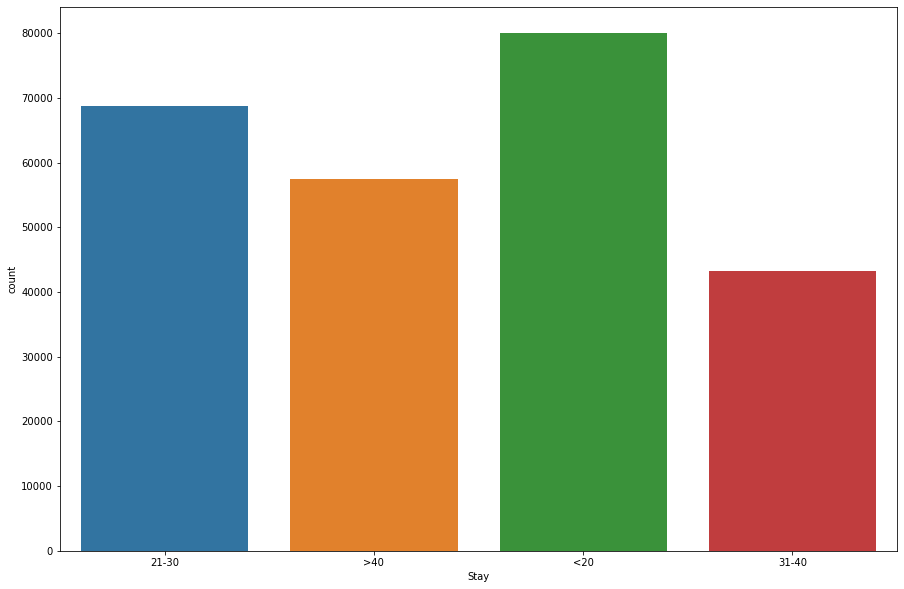

In [86]:
sns.countplot(y_train);

In [87]:
y_train = y_train.map({'<20':0,'21-30':1,'31-40':2, '>40':3 })
y_test = y_test.map({'<20':0,'21-30':1,'31-40':2, '>40':3 })

<AxesSubplot:xlabel='Stay', ylabel='count'>

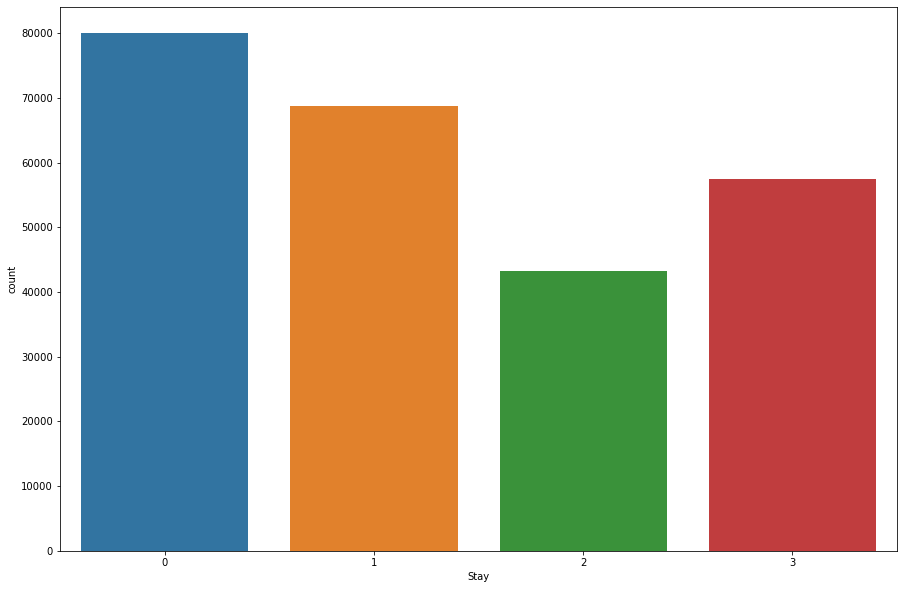

In [88]:
sns.countplot(y_train)

# Model Building

In [89]:
value= [LogisticRegression(), RandomForestClassifier(), DecisionTreeClassifier(), KNeighborsClassifier(), CatBoostClassifier(), XGBClassifier(), LGBMClassifier()]

key= ['LogisticRegression', 'RandomForsetClassifier', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'CatBoostClassifier', 'XGBClassifier', 'LGBMClassifier']

models= dict(zip(key,value))
accuracy_scores=[]
for key,value in models.items():
    value.fit(X_train_new,y_train)
    y_pred= value.predict(X_test_new)
    accuracy= accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    print(key)
    print("Accuracy:", accuracy)

LogisticRegression
Accuracy: 0.4897805300648142
RandomForsetClassifier
Accuracy: 0.4837483154719887
DecisionTreeClassifier
Accuracy: 0.3929281909773471
KNeighborsClassifier
Accuracy: 0.4161586344092922
Learning rate set to 0.104848
0:	learn: 1.3460687	total: 320ms	remaining: 5m 19s
1:	learn: 1.3149429	total: 422ms	remaining: 3m 30s
2:	learn: 1.2898389	total: 522ms	remaining: 2m 53s
3:	learn: 1.2694552	total: 620ms	remaining: 2m 34s
4:	learn: 1.2532903	total: 715ms	remaining: 2m 22s
5:	learn: 1.2392668	total: 830ms	remaining: 2m 17s
6:	learn: 1.2275383	total: 952ms	remaining: 2m 15s
7:	learn: 1.2179893	total: 1.05s	remaining: 2m 10s
8:	learn: 1.2090685	total: 1.16s	remaining: 2m 8s
9:	learn: 1.2022754	total: 1.3s	remaining: 2m 8s
10:	learn: 1.1960548	total: 1.41s	remaining: 2m 6s
11:	learn: 1.1905394	total: 1.63s	remaining: 2m 14s
12:	learn: 1.1855608	total: 1.76s	remaining: 2m 13s
13:	learn: 1.1816274	total: 1.88s	remaining: 2m 12s
14:	learn: 1.1780124	total: 2.04s	remaining: 2m 13s
15

155:	learn: 1.1150289	total: 19.8s	remaining: 1m 47s
156:	learn: 1.1148700	total: 19.9s	remaining: 1m 47s
157:	learn: 1.1147252	total: 20.1s	remaining: 1m 46s
158:	learn: 1.1146220	total: 20.2s	remaining: 1m 46s
159:	learn: 1.1145359	total: 20.3s	remaining: 1m 46s
160:	learn: 1.1143882	total: 20.4s	remaining: 1m 46s
161:	learn: 1.1142823	total: 20.6s	remaining: 1m 46s
162:	learn: 1.1141818	total: 20.8s	remaining: 1m 46s
163:	learn: 1.1140713	total: 20.9s	remaining: 1m 46s
164:	learn: 1.1139554	total: 21s	remaining: 1m 46s
165:	learn: 1.1138177	total: 21.1s	remaining: 1m 45s
166:	learn: 1.1136532	total: 21.2s	remaining: 1m 45s
167:	learn: 1.1135526	total: 21.4s	remaining: 1m 45s
168:	learn: 1.1134407	total: 21.5s	remaining: 1m 45s
169:	learn: 1.1133712	total: 21.6s	remaining: 1m 45s
170:	learn: 1.1131151	total: 21.8s	remaining: 1m 45s
171:	learn: 1.1130143	total: 22s	remaining: 1m 45s
172:	learn: 1.1129281	total: 22.1s	remaining: 1m 45s
173:	learn: 1.1127547	total: 22.2s	remaining: 1m 4

311:	learn: 1.1002125	total: 38.7s	remaining: 1m 25s
312:	learn: 1.1001381	total: 38.9s	remaining: 1m 25s
313:	learn: 1.1000684	total: 39s	remaining: 1m 25s
314:	learn: 1.0999915	total: 39.1s	remaining: 1m 25s
315:	learn: 1.0999270	total: 39.2s	remaining: 1m 24s
316:	learn: 1.0998562	total: 39.3s	remaining: 1m 24s
317:	learn: 1.0998005	total: 39.5s	remaining: 1m 24s
318:	learn: 1.0997084	total: 39.6s	remaining: 1m 24s
319:	learn: 1.0996525	total: 39.7s	remaining: 1m 24s
320:	learn: 1.0996002	total: 39.8s	remaining: 1m 24s
321:	learn: 1.0995279	total: 39.9s	remaining: 1m 24s
322:	learn: 1.0994898	total: 40s	remaining: 1m 23s
323:	learn: 1.0994471	total: 40.2s	remaining: 1m 23s
324:	learn: 1.0993832	total: 40.3s	remaining: 1m 23s
325:	learn: 1.0992981	total: 40.4s	remaining: 1m 23s
326:	learn: 1.0991933	total: 40.5s	remaining: 1m 23s
327:	learn: 1.0991271	total: 40.7s	remaining: 1m 23s
328:	learn: 1.0990583	total: 40.8s	remaining: 1m 23s
329:	learn: 1.0989991	total: 40.9s	remaining: 1m 2

468:	learn: 1.0900444	total: 57.2s	remaining: 1m 4s
469:	learn: 1.0899701	total: 57.3s	remaining: 1m 4s
470:	learn: 1.0898985	total: 57.5s	remaining: 1m 4s
471:	learn: 1.0898307	total: 57.6s	remaining: 1m 4s
472:	learn: 1.0897879	total: 57.7s	remaining: 1m 4s
473:	learn: 1.0897272	total: 57.8s	remaining: 1m 4s
474:	learn: 1.0896806	total: 57.9s	remaining: 1m 4s
475:	learn: 1.0896064	total: 58.1s	remaining: 1m 3s
476:	learn: 1.0895632	total: 58.2s	remaining: 1m 3s
477:	learn: 1.0895039	total: 58.3s	remaining: 1m 3s
478:	learn: 1.0894593	total: 58.4s	remaining: 1m 3s
479:	learn: 1.0894015	total: 58.5s	remaining: 1m 3s
480:	learn: 1.0893592	total: 58.6s	remaining: 1m 3s
481:	learn: 1.0892829	total: 58.7s	remaining: 1m 3s
482:	learn: 1.0892116	total: 58.8s	remaining: 1m 2s
483:	learn: 1.0891471	total: 58.9s	remaining: 1m 2s
484:	learn: 1.0890990	total: 59.1s	remaining: 1m 2s
485:	learn: 1.0890269	total: 59.2s	remaining: 1m 2s
486:	learn: 1.0889961	total: 59.3s	remaining: 1m 2s
487:	learn: 

627:	learn: 1.0817252	total: 1m 15s	remaining: 44.8s
628:	learn: 1.0816773	total: 1m 15s	remaining: 44.7s
629:	learn: 1.0816398	total: 1m 15s	remaining: 44.5s
630:	learn: 1.0815766	total: 1m 16s	remaining: 44.5s
631:	learn: 1.0815241	total: 1m 16s	remaining: 44.3s
632:	learn: 1.0814887	total: 1m 16s	remaining: 44.2s
633:	learn: 1.0814261	total: 1m 16s	remaining: 44.1s
634:	learn: 1.0813777	total: 1m 16s	remaining: 44s
635:	learn: 1.0813270	total: 1m 16s	remaining: 43.9s
636:	learn: 1.0812910	total: 1m 16s	remaining: 43.8s
637:	learn: 1.0812398	total: 1m 16s	remaining: 43.6s
638:	learn: 1.0811949	total: 1m 17s	remaining: 43.5s
639:	learn: 1.0811641	total: 1m 17s	remaining: 43.4s
640:	learn: 1.0810969	total: 1m 17s	remaining: 43.3s
641:	learn: 1.0810400	total: 1m 17s	remaining: 43.2s
642:	learn: 1.0809966	total: 1m 17s	remaining: 43.1s
643:	learn: 1.0809371	total: 1m 17s	remaining: 43s
644:	learn: 1.0808880	total: 1m 17s	remaining: 42.8s
645:	learn: 1.0808211	total: 1m 17s	remaining: 42.

783:	learn: 1.0744936	total: 1m 34s	remaining: 25.9s
784:	learn: 1.0744429	total: 1m 34s	remaining: 25.8s
785:	learn: 1.0744151	total: 1m 34s	remaining: 25.7s
786:	learn: 1.0743724	total: 1m 34s	remaining: 25.6s
787:	learn: 1.0743178	total: 1m 34s	remaining: 25.4s
788:	learn: 1.0742934	total: 1m 34s	remaining: 25.3s
789:	learn: 1.0742613	total: 1m 34s	remaining: 25.2s
790:	learn: 1.0742150	total: 1m 34s	remaining: 25.1s
791:	learn: 1.0741785	total: 1m 35s	remaining: 25s
792:	learn: 1.0741366	total: 1m 35s	remaining: 24.8s
793:	learn: 1.0740995	total: 1m 35s	remaining: 24.7s
794:	learn: 1.0740670	total: 1m 35s	remaining: 24.6s
795:	learn: 1.0740133	total: 1m 35s	remaining: 24.5s
796:	learn: 1.0739696	total: 1m 35s	remaining: 24.3s
797:	learn: 1.0739075	total: 1m 35s	remaining: 24.2s
798:	learn: 1.0738700	total: 1m 35s	remaining: 24.1s
799:	learn: 1.0738264	total: 1m 35s	remaining: 24s
800:	learn: 1.0737831	total: 1m 36s	remaining: 23.9s
801:	learn: 1.0737404	total: 1m 36s	remaining: 23.

939:	learn: 1.0677702	total: 1m 52s	remaining: 7.17s
940:	learn: 1.0677111	total: 1m 52s	remaining: 7.06s
941:	learn: 1.0676753	total: 1m 52s	remaining: 6.94s
942:	learn: 1.0676367	total: 1m 52s	remaining: 6.82s
943:	learn: 1.0675771	total: 1m 52s	remaining: 6.7s
944:	learn: 1.0675276	total: 1m 53s	remaining: 6.58s
945:	learn: 1.0674954	total: 1m 53s	remaining: 6.46s
946:	learn: 1.0674488	total: 1m 53s	remaining: 6.34s
947:	learn: 1.0674186	total: 1m 53s	remaining: 6.22s
948:	learn: 1.0673931	total: 1m 53s	remaining: 6.1s
949:	learn: 1.0673390	total: 1m 53s	remaining: 5.98s
950:	learn: 1.0673056	total: 1m 53s	remaining: 5.86s
951:	learn: 1.0672817	total: 1m 53s	remaining: 5.74s
952:	learn: 1.0672493	total: 1m 53s	remaining: 5.62s
953:	learn: 1.0672027	total: 1m 54s	remaining: 5.5s
954:	learn: 1.0671494	total: 1m 54s	remaining: 5.38s
955:	learn: 1.0671060	total: 1m 54s	remaining: 5.26s
956:	learn: 1.0670374	total: 1m 54s	remaining: 5.14s
957:	learn: 1.0670064	total: 1m 54s	remaining: 5.

In [90]:
train_pool = Pool(data=X_train_new, label=y_train)
test_pool = Pool(data=X_test_new, label=y_test.values) 

In [91]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    random_strength=0.1,
    depth=8,
    loss_function='MultiClass',
    classes_count=len(set(y_train)),
    eval_metric="Accuracy",
    leaf_estimation_method='Newton'
)

In [92]:
model.fit(train_pool,plot=True,eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4815923	test: 0.4807162	best: 0.4807162 (0)	total: 192ms	remaining: 3m 11s
1:	learn: 0.4815923	test: 0.4808445	best: 0.4808445 (1)	total: 391ms	remaining: 3m 15s
2:	learn: 0.4840469	test: 0.4835398	best: 0.4835398 (2)	total: 595ms	remaining: 3m 17s
3:	learn: 0.4843558	test: 0.4831708	best: 0.4835398 (2)	total: 817ms	remaining: 3m 23s
4:	learn: 0.4850456	test: 0.4845184	best: 0.4845184 (4)	total: 1s	remaining: 3m 19s
5:	learn: 0.4867181	test: 0.4862992	best: 0.4862992 (5)	total: 1.19s	remaining: 3m 17s
6:	learn: 0.4867984	test: 0.4853526	best: 0.4862992 (5)	total: 1.39s	remaining: 3m 17s
7:	learn: 0.4870831	test: 0.4859783	best: 0.4862992 (5)	total: 1.57s	remaining: 3m 15s
8:	learn: 0.4875765	test: 0.4862831	best: 0.4862992 (5)	total: 1.78s	remaining: 3m 16s
9:	learn: 0.4876807	test: 0.4869730	best: 0.4869730 (9)	total: 1.99s	remaining: 3m 16s
10:	learn: 0.4887436	test: 0.4868767	best: 0.4869730 (9)	total: 2.18s	remaining: 3m 16s
11:	learn: 0.4893412	test: 0.4872938	best: 0.

94:	learn: 0.5141362	test: 0.5059039	best: 0.5059039 (94)	total: 17.6s	remaining: 2m 47s
95:	learn: 0.5142284	test: 0.5059841	best: 0.5059841 (95)	total: 17.8s	remaining: 2m 47s
96:	learn: 0.5144891	test: 0.5059520	best: 0.5059841 (95)	total: 18s	remaining: 2m 47s
97:	learn: 0.5146335	test: 0.5060162	best: 0.5060162 (97)	total: 18.2s	remaining: 2m 47s
98:	learn: 0.5147699	test: 0.5061124	best: 0.5061124 (98)	total: 18.3s	remaining: 2m 46s
99:	learn: 0.5149664	test: 0.5061124	best: 0.5061124 (98)	total: 18.5s	remaining: 2m 46s
100:	learn: 0.5150948	test: 0.5065135	best: 0.5065135 (100)	total: 18.7s	remaining: 2m 46s
101:	learn: 0.5153154	test: 0.5064333	best: 0.5065135 (100)	total: 18.9s	remaining: 2m 46s
102:	learn: 0.5154597	test: 0.5065616	best: 0.5065616 (102)	total: 19.1s	remaining: 2m 46s
103:	learn: 0.5154678	test: 0.5066098	best: 0.5066098 (103)	total: 19.3s	remaining: 2m 45s
104:	learn: 0.5155480	test: 0.5065456	best: 0.5066098 (103)	total: 19.4s	remaining: 2m 45s
105:	learn: 0

186:	learn: 0.5240630	test: 0.5090965	best: 0.5090965 (186)	total: 34.4s	remaining: 2m 29s
187:	learn: 0.5240509	test: 0.5090965	best: 0.5090965 (186)	total: 34.5s	remaining: 2m 29s
188:	learn: 0.5240630	test: 0.5092408	best: 0.5092408 (188)	total: 34.7s	remaining: 2m 28s
189:	learn: 0.5240991	test: 0.5090804	best: 0.5092408 (188)	total: 34.9s	remaining: 2m 28s
190:	learn: 0.5242114	test: 0.5088558	best: 0.5092408 (188)	total: 35.1s	remaining: 2m 28s
191:	learn: 0.5242234	test: 0.5091125	best: 0.5092408 (188)	total: 35.3s	remaining: 2m 28s
192:	learn: 0.5243919	test: 0.5091446	best: 0.5092408 (188)	total: 35.5s	remaining: 2m 28s
193:	learn: 0.5243999	test: 0.5090644	best: 0.5092408 (188)	total: 35.6s	remaining: 2m 28s
194:	learn: 0.5245282	test: 0.5092729	best: 0.5092729 (194)	total: 35.8s	remaining: 2m 27s
195:	learn: 0.5246526	test: 0.5089681	best: 0.5092729 (194)	total: 36s	remaining: 2m 27s
196:	learn: 0.5248250	test: 0.5092729	best: 0.5092729 (194)	total: 36.2s	remaining: 2m 27s
1

277:	learn: 0.5315793	test: 0.5110056	best: 0.5110056 (277)	total: 51s	remaining: 2m 12s
278:	learn: 0.5315512	test: 0.5108452	best: 0.5110056 (277)	total: 51.2s	remaining: 2m 12s
279:	learn: 0.5316354	test: 0.5111981	best: 0.5111981 (279)	total: 51.4s	remaining: 2m 12s
280:	learn: 0.5316154	test: 0.5113585	best: 0.5113585 (280)	total: 51.6s	remaining: 2m 11s
281:	learn: 0.5316956	test: 0.5112302	best: 0.5113585 (280)	total: 51.8s	remaining: 2m 11s
282:	learn: 0.5318841	test: 0.5112302	best: 0.5113585 (280)	total: 52s	remaining: 2m 11s
283:	learn: 0.5319884	test: 0.5112302	best: 0.5113585 (280)	total: 52.1s	remaining: 2m 11s
284:	learn: 0.5319763	test: 0.5111981	best: 0.5113585 (280)	total: 52.3s	remaining: 2m 11s
285:	learn: 0.5320405	test: 0.5112623	best: 0.5113585 (280)	total: 52.5s	remaining: 2m 11s
286:	learn: 0.5322451	test: 0.5113425	best: 0.5113585 (280)	total: 52.7s	remaining: 2m 10s
287:	learn: 0.5323052	test: 0.5111821	best: 0.5113585 (280)	total: 52.9s	remaining: 2m 10s
288

370:	learn: 0.5384017	test: 0.5118719	best: 0.5123692 (358)	total: 1m 8s	remaining: 1m 55s
371:	learn: 0.5384418	test: 0.5120644	best: 0.5123692 (358)	total: 1m 8s	remaining: 1m 55s
372:	learn: 0.5385381	test: 0.5121928	best: 0.5123692 (358)	total: 1m 8s	remaining: 1m 55s
373:	learn: 0.5385661	test: 0.5120965	best: 0.5123692 (358)	total: 1m 8s	remaining: 1m 55s
374:	learn: 0.5386463	test: 0.5121126	best: 0.5123692 (358)	total: 1m 8s	remaining: 1m 54s
375:	learn: 0.5388549	test: 0.5119040	best: 0.5123692 (358)	total: 1m 9s	remaining: 1m 54s
376:	learn: 0.5389151	test: 0.5120644	best: 0.5123692 (358)	total: 1m 9s	remaining: 1m 54s
377:	learn: 0.5389472	test: 0.5121126	best: 0.5123692 (358)	total: 1m 9s	remaining: 1m 54s
378:	learn: 0.5391036	test: 0.5121286	best: 0.5123692 (358)	total: 1m 9s	remaining: 1m 54s
379:	learn: 0.5391718	test: 0.5121286	best: 0.5123692 (358)	total: 1m 9s	remaining: 1m 53s
380:	learn: 0.5392961	test: 0.5120965	best: 0.5123692 (358)	total: 1m 10s	remaining: 1m 53

460:	learn: 0.5447789	test: 0.5119842	best: 0.5127062 (404)	total: 1m 25s	remaining: 1m 40s
461:	learn: 0.5448872	test: 0.5120484	best: 0.5127062 (404)	total: 1m 25s	remaining: 1m 39s
462:	learn: 0.5448471	test: 0.5119842	best: 0.5127062 (404)	total: 1m 25s	remaining: 1m 39s
463:	learn: 0.5448792	test: 0.5119521	best: 0.5127062 (404)	total: 1m 26s	remaining: 1m 39s
464:	learn: 0.5450196	test: 0.5119200	best: 0.5127062 (404)	total: 1m 26s	remaining: 1m 39s
465:	learn: 0.5450356	test: 0.5118398	best: 0.5127062 (404)	total: 1m 26s	remaining: 1m 39s
466:	learn: 0.5450115	test: 0.5120965	best: 0.5127062 (404)	total: 1m 26s	remaining: 1m 38s
467:	learn: 0.5451078	test: 0.5120323	best: 0.5127062 (404)	total: 1m 26s	remaining: 1m 38s
468:	learn: 0.5451720	test: 0.5120484	best: 0.5127062 (404)	total: 1m 27s	remaining: 1m 38s
469:	learn: 0.5451319	test: 0.5119040	best: 0.5127062 (404)	total: 1m 27s	remaining: 1m 38s
470:	learn: 0.5452562	test: 0.5118559	best: 0.5127062 (404)	total: 1m 27s	remain

550:	learn: 0.5510919	test: 0.5123372	best: 0.5131233 (539)	total: 1m 42s	remaining: 1m 23s
551:	learn: 0.5511280	test: 0.5126099	best: 0.5131233 (539)	total: 1m 42s	remaining: 1m 23s
552:	learn: 0.5511481	test: 0.5126099	best: 0.5131233 (539)	total: 1m 43s	remaining: 1m 23s
553:	learn: 0.5511922	test: 0.5126099	best: 0.5131233 (539)	total: 1m 43s	remaining: 1m 23s
554:	learn: 0.5513527	test: 0.5124976	best: 0.5131233 (539)	total: 1m 43s	remaining: 1m 22s
555:	learn: 0.5515131	test: 0.5125939	best: 0.5131233 (539)	total: 1m 43s	remaining: 1m 22s
556:	learn: 0.5515612	test: 0.5124816	best: 0.5131233 (539)	total: 1m 43s	remaining: 1m 22s
557:	learn: 0.5515893	test: 0.5124655	best: 0.5131233 (539)	total: 1m 43s	remaining: 1m 22s
558:	learn: 0.5516655	test: 0.5124655	best: 0.5131233 (539)	total: 1m 44s	remaining: 1m 22s
559:	learn: 0.5518340	test: 0.5125297	best: 0.5131233 (539)	total: 1m 44s	remaining: 1m 21s
560:	learn: 0.5518620	test: 0.5124013	best: 0.5131233 (539)	total: 1m 44s	remain

641:	learn: 0.5568836	test: 0.5135404	best: 0.5136848 (638)	total: 2m	remaining: 1m 6s
642:	learn: 0.5568996	test: 0.5136527	best: 0.5136848 (638)	total: 2m	remaining: 1m 6s
643:	learn: 0.5569798	test: 0.5134923	best: 0.5136848 (638)	total: 2m	remaining: 1m 6s
644:	learn: 0.5571443	test: 0.5135725	best: 0.5136848 (638)	total: 2m	remaining: 1m 6s
645:	learn: 0.5572045	test: 0.5137008	best: 0.5137008 (645)	total: 2m	remaining: 1m 6s
646:	learn: 0.5571964	test: 0.5137008	best: 0.5137008 (645)	total: 2m 1s	remaining: 1m 6s
647:	learn: 0.5572726	test: 0.5137169	best: 0.5137169 (647)	total: 2m 1s	remaining: 1m 5s
648:	learn: 0.5573328	test: 0.5136527	best: 0.5137169 (647)	total: 2m 1s	remaining: 1m 5s
649:	learn: 0.5573890	test: 0.5135885	best: 0.5137169 (647)	total: 2m 1s	remaining: 1m 5s
650:	learn: 0.5573208	test: 0.5136046	best: 0.5137169 (647)	total: 2m 1s	remaining: 1m 5s
651:	learn: 0.5573809	test: 0.5134762	best: 0.5137169 (647)	total: 2m 1s	remaining: 1m 5s
652:	learn: 0.5574451	tes

733:	learn: 0.5631445	test: 0.5132677	best: 0.5137329 (654)	total: 2m 17s	remaining: 50s
734:	learn: 0.5631806	test: 0.5134602	best: 0.5137329 (654)	total: 2m 18s	remaining: 49.8s
735:	learn: 0.5632287	test: 0.5135404	best: 0.5137329 (654)	total: 2m 18s	remaining: 49.6s
736:	learn: 0.5633651	test: 0.5134762	best: 0.5137329 (654)	total: 2m 18s	remaining: 49.4s
737:	learn: 0.5634293	test: 0.5132035	best: 0.5137329 (654)	total: 2m 18s	remaining: 49.2s
738:	learn: 0.5635977	test: 0.5132195	best: 0.5137329 (654)	total: 2m 18s	remaining: 49s
739:	learn: 0.5636057	test: 0.5132997	best: 0.5137329 (654)	total: 2m 19s	remaining: 48.9s
740:	learn: 0.5636338	test: 0.5134602	best: 0.5137329 (654)	total: 2m 19s	remaining: 48.7s
741:	learn: 0.5637301	test: 0.5135404	best: 0.5137329 (654)	total: 2m 19s	remaining: 48.5s
742:	learn: 0.5637662	test: 0.5134121	best: 0.5137329 (654)	total: 2m 19s	remaining: 48.3s
743:	learn: 0.5638063	test: 0.5133158	best: 0.5137329 (654)	total: 2m 19s	remaining: 48.1s
744

824:	learn: 0.5689802	test: 0.5140538	best: 0.5144709 (804)	total: 2m 38s	remaining: 33.7s
825:	learn: 0.5690845	test: 0.5140377	best: 0.5144709 (804)	total: 2m 39s	remaining: 33.5s
826:	learn: 0.5690364	test: 0.5139094	best: 0.5144709 (804)	total: 2m 39s	remaining: 33.3s
827:	learn: 0.5693051	test: 0.5138292	best: 0.5144709 (804)	total: 2m 39s	remaining: 33.2s
828:	learn: 0.5693452	test: 0.5138452	best: 0.5144709 (804)	total: 2m 39s	remaining: 33s
829:	learn: 0.5693773	test: 0.5139254	best: 0.5144709 (804)	total: 2m 40s	remaining: 32.8s
830:	learn: 0.5694816	test: 0.5137650	best: 0.5144709 (804)	total: 2m 40s	remaining: 32.6s
831:	learn: 0.5694575	test: 0.5137650	best: 0.5144709 (804)	total: 2m 40s	remaining: 32.4s
832:	learn: 0.5695698	test: 0.5138131	best: 0.5144709 (804)	total: 2m 40s	remaining: 32.3s
833:	learn: 0.5695698	test: 0.5138131	best: 0.5144709 (804)	total: 2m 41s	remaining: 32.1s
834:	learn: 0.5696420	test: 0.5139254	best: 0.5144709 (804)	total: 2m 41s	remaining: 31.9s
8

915:	learn: 0.5748040	test: 0.5128666	best: 0.5144709 (804)	total: 3m 2s	remaining: 16.7s
916:	learn: 0.5748240	test: 0.5128185	best: 0.5144709 (804)	total: 3m 2s	remaining: 16.5s
917:	learn: 0.5749002	test: 0.5128826	best: 0.5144709 (804)	total: 3m 2s	remaining: 16.3s
918:	learn: 0.5749965	test: 0.5130270	best: 0.5144709 (804)	total: 3m 2s	remaining: 16.1s
919:	learn: 0.5750647	test: 0.5129468	best: 0.5144709 (804)	total: 3m 3s	remaining: 15.9s
920:	learn: 0.5751810	test: 0.5130431	best: 0.5144709 (804)	total: 3m 3s	remaining: 15.7s
921:	learn: 0.5751489	test: 0.5128987	best: 0.5144709 (804)	total: 3m 3s	remaining: 15.5s
922:	learn: 0.5752412	test: 0.5127543	best: 0.5144709 (804)	total: 3m 3s	remaining: 15.3s
923:	learn: 0.5752933	test: 0.5126580	best: 0.5144709 (804)	total: 3m 3s	remaining: 15.1s
924:	learn: 0.5754858	test: 0.5126901	best: 0.5144709 (804)	total: 3m 4s	remaining: 14.9s
925:	learn: 0.5755620	test: 0.5127062	best: 0.5144709 (804)	total: 3m 4s	remaining: 14.7s
926:	learn

In [93]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    print(best_params)
    print()
    return best_params

In [94]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Catboostclassifier

### Initialize domain space for range of values

In [95]:
# Defining your search space
search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 12),
                 'learning_rate': Real(0.001, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 60)}

### objective function

In [96]:
clf = CatBoostClassifier(thread_count=2, 
                         loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         leaf_estimation_method='Newton', 
                         classes_count=len(set(y_train)), 
                         od_type = 'Iter', 
                         verbose= False)

### Optimization algorithm

In [97]:
# Setting up BayesSearchCV
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring='accuracy',
                    cv=skf,
                    n_iter=50,
                    n_jobs=1,  # used just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [98]:
best_params = report_perf(opt, X_train_new, y_train,'CatBoost', 
                         callbacks=[VerboseCallback(100), 
                                    DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 1230.3928
Function value obtained: -0.5044
Current minimum: -0.5044
Iteration No: 2 started. Searching for the next optimal point.
CatBoost took 1490.99 seconds,  checked: 1, best CV score: 0.504 ± 0.002
Best parameters:
OrderedDict([('bagging_temperature', 0.41010395885331385), ('border_count', 186), ('depth', 11), ('iterations', 323), ('l2_leaf_reg', 41), ('learning_rate', 0.017472534129202036), ('random_strength', 3.230824361824754e-06)])



### Tuned Model

In [99]:
tuned_model = CatBoostClassifier(
    iterations=323,
    learning_rate=0.017472534129202036,
    random_strength=3.230824361824754e-06,
    depth=11,
    loss_function='MultiClass',
    classes_count=len(set(y_train)),
    eval_metric="Accuracy",
    leaf_estimation_method='Newton',
    bagging_temperature=0.41010395885331385,
    border_count=186,
    l2_leaf_reg = 41
)

In [100]:
tuned_model.fit(train_pool,plot=True,eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4914429	test: 0.4867805	best: 0.4867805 (0)	total: 474ms	remaining: 2m 32s
1:	learn: 0.4916795	test: 0.4870532	best: 0.4870532 (1)	total: 967ms	remaining: 2m 35s
2:	learn: 0.4916274	test: 0.4867323	best: 0.4870532 (1)	total: 1.44s	remaining: 2m 33s
3:	learn: 0.4918319	test: 0.4869088	best: 0.4870532 (1)	total: 1.94s	remaining: 2m 34s
4:	learn: 0.4921047	test: 0.4876789	best: 0.4876789 (4)	total: 2.42s	remaining: 2m 33s
5:	learn: 0.4922651	test: 0.4876147	best: 0.4876789 (4)	total: 2.91s	remaining: 2m 33s
6:	learn: 0.4927705	test: 0.4875505	best: 0.4876789 (4)	total: 3.38s	remaining: 2m 32s
7:	learn: 0.4928828	test: 0.4873901	best: 0.4876789 (4)	total: 3.83s	remaining: 2m 30s
8:	learn: 0.4927825	test: 0.4874543	best: 0.4876789 (4)	total: 4.29s	remaining: 2m 29s
9:	learn: 0.4927865	test: 0.4874382	best: 0.4876789 (4)	total: 4.8s	remaining: 2m 30s
10:	learn: 0.4929670	test: 0.4875184	best: 0.4876789 (4)	total: 5.31s	remaining: 2m 30s
11:	learn: 0.4928547	test: 0.4872136	best: 

93:	learn: 0.4993362	test: 0.4940961	best: 0.4940961 (93)	total: 45.1s	remaining: 1m 49s
94:	learn: 0.4994405	test: 0.4940480	best: 0.4940961 (93)	total: 45.6s	remaining: 1m 49s
95:	learn: 0.4994365	test: 0.4941443	best: 0.4941443 (95)	total: 46.1s	remaining: 1m 48s
96:	learn: 0.4995929	test: 0.4942405	best: 0.4942405 (96)	total: 46.6s	remaining: 1m 48s
97:	learn: 0.4996691	test: 0.4942566	best: 0.4942566 (97)	total: 47s	remaining: 1m 48s
98:	learn: 0.4996932	test: 0.4941282	best: 0.4942566 (97)	total: 47.5s	remaining: 1m 47s
99:	learn: 0.4996491	test: 0.4941603	best: 0.4942566 (97)	total: 48s	remaining: 1m 47s
100:	learn: 0.4995809	test: 0.4940640	best: 0.4942566 (97)	total: 48.5s	remaining: 1m 46s
101:	learn: 0.4997212	test: 0.4942886	best: 0.4942886 (101)	total: 49s	remaining: 1m 46s
102:	learn: 0.4998576	test: 0.4944330	best: 0.4944330 (102)	total: 49.4s	remaining: 1m 45s
103:	learn: 0.4999820	test: 0.4945774	best: 0.4945774 (103)	total: 49.9s	remaining: 1m 45s
104:	learn: 0.500162

183:	learn: 0.5059942	test: 0.4987807	best: 0.4988449 (182)	total: 1m 30s	remaining: 1m 8s
184:	learn: 0.5061707	test: 0.4988930	best: 0.4988930 (184)	total: 1m 31s	remaining: 1m 8s
185:	learn: 0.5061546	test: 0.4991016	best: 0.4991016 (185)	total: 1m 31s	remaining: 1m 7s
186:	learn: 0.5062268	test: 0.4990535	best: 0.4991016 (185)	total: 1m 32s	remaining: 1m 7s
187:	learn: 0.5062830	test: 0.4990695	best: 0.4991016 (185)	total: 1m 32s	remaining: 1m 6s
188:	learn: 0.5063993	test: 0.4992139	best: 0.4992139 (188)	total: 1m 33s	remaining: 1m 6s
189:	learn: 0.5063792	test: 0.4991658	best: 0.4992139 (188)	total: 1m 33s	remaining: 1m 5s
190:	learn: 0.5064354	test: 0.4992941	best: 0.4992941 (190)	total: 1m 34s	remaining: 1m 5s
191:	learn: 0.5064715	test: 0.4992781	best: 0.4992941 (190)	total: 1m 34s	remaining: 1m 4s
192:	learn: 0.5065597	test: 0.4993743	best: 0.4993743 (192)	total: 1m 35s	remaining: 1m 4s
193:	learn: 0.5067081	test: 0.4992620	best: 0.4993743 (192)	total: 1m 35s	remaining: 1m 3s

274:	learn: 0.5107831	test: 0.5024065	best: 0.5024225 (271)	total: 2m 26s	remaining: 25.6s
275:	learn: 0.5108874	test: 0.5025188	best: 0.5025188 (275)	total: 2m 27s	remaining: 25s
276:	learn: 0.5109195	test: 0.5026311	best: 0.5026311 (276)	total: 2m 27s	remaining: 24.5s
277:	learn: 0.5109275	test: 0.5025348	best: 0.5026311 (276)	total: 2m 28s	remaining: 24s
278:	learn: 0.5109315	test: 0.5026150	best: 0.5026311 (276)	total: 2m 28s	remaining: 23.4s
279:	learn: 0.5109917	test: 0.5026311	best: 0.5026311 (276)	total: 2m 29s	remaining: 22.9s
280:	learn: 0.5109756	test: 0.5027273	best: 0.5027273 (280)	total: 2m 29s	remaining: 22.4s
281:	learn: 0.5110278	test: 0.5026792	best: 0.5027273 (280)	total: 2m 30s	remaining: 21.8s
282:	learn: 0.5111361	test: 0.5026952	best: 0.5027273 (280)	total: 2m 30s	remaining: 21.3s
283:	learn: 0.5111441	test: 0.5027113	best: 0.5027273 (280)	total: 2m 31s	remaining: 20.8s
284:	learn: 0.5112163	test: 0.5026952	best: 0.5027273 (280)	total: 2m 31s	remaining: 20.2s
285

In [101]:
y_pred_train = tuned_model.predict(X_train_new)
print("Accuracy on training data", accuracy_score(y_train, y_pred_train))

Accuracy on training data 0.5124275543968716


In [102]:
y_pred_test = tuned_model.predict(X_test_new)
print("Accuracy on testing data", accuracy_score(y_test, y_pred_test))

Accuracy on testing data 0.5038343066161843


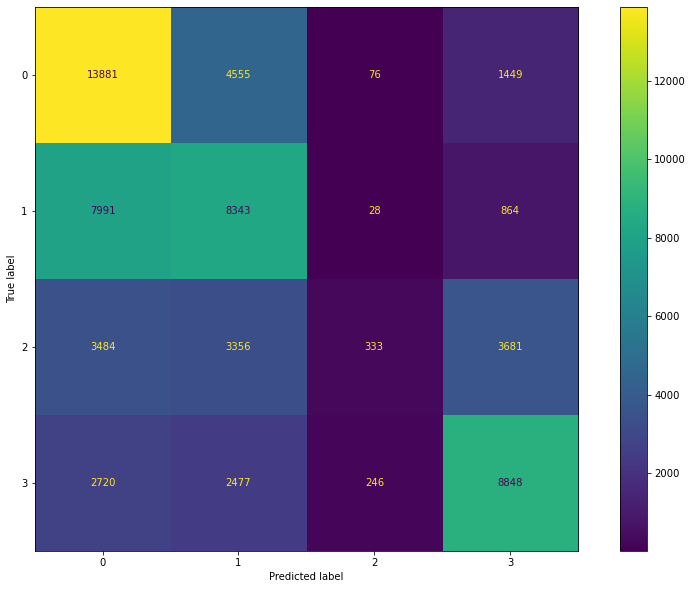

In [103]:
plot_confusion_matrix(estimator=tuned_model, X=X_test_new, y_true=y_test);

In [104]:
pd.DataFrame({'feature_importance': tuned_model.get_feature_importance(train_pool), 
              'feature_names': X_train_new.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
61,46.253007,Visitors with Patient_more
25,6.951989,Ward_Type_Q
1,4.767537,Admission_Deposit
0,4.468629,Available Extra Rooms in Hospital
57,3.856827,Type of Admission_Trauma
...,...,...
18,0.000000,City_Code_Hospital_11
41,0.000000,City_Code_Patient_9.0
36,0.000000,City_Code_Patient_4.0
23,0.000000,Department_radiotherapy


In [105]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

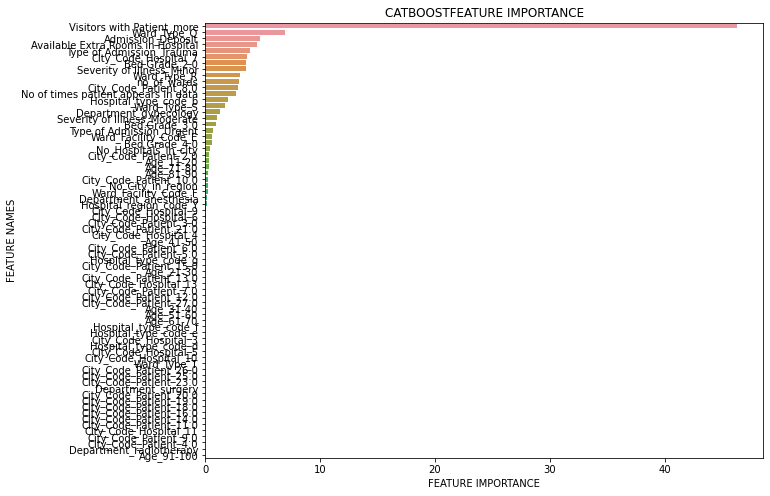

In [106]:

#plot the catboost result
plot_feature_importance(tuned_model.get_feature_importance(),X_train_new.columns,'CATBOOST')

##  XGBoostClassifier

### Initialize domain space for range of values

In [107]:
search_space_xgb = {
    "learning_rate": (0.01, 1.0, "log-uniform"),
    "min_child_weight": (0, 10),
    "max_depth": (1, 50),
    "max_delta_step": (0, 10),
    "subsample": (0.01, 1.0, "uniform"),
    "colsample_bytree": (0.01, 1.0, "log-uniform"),
    "colsample_bylevel": (0.01, 1.0, "log-uniform"),
    "reg_lambda": (1e-9, 1.0, "log-uniform"),
    "reg_alpha": (1e-9, 1.0, "log-uniform"),
    "gamma": (1e-9, 0.5, "log-uniform"),
    "min_child_weight": (0, 5),
    "n_estimators": (5, 5000)
}

### objective function

In [108]:
estimator_xgb = XGBClassifier(
    n_jobs=-1,
    objective="multi:softmax",
    eval_metric="merror",
    verbosity=0,
    num_class=len(set(y_train)),
)

### Optimization algorithm

In [109]:
bayes_cv_tuner = BayesSearchCV(
    estimator=estimator_xgb,
    search_spaces=search_space_xgb,
    scoring="accuracy",
    cv=skf,
    n_jobs=-1,
    n_iter=100,
    verbose=0,
    refit=True,
)

In [110]:
best_params_xgb = report_perf(bayes_cv_tuner , X_train_new, y_train,'Xgboost', 
                         callbacks=[VerboseCallback(100), 
                                    DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 767.2055
Function value obtained: -0.5055
Current minimum: -0.5055
Iteration No: 2 started. Searching for the next optimal point.
Xgboost took 1106.09 seconds,  checked: 1, best CV score: 0.506 ± 0.002
Best parameters:
OrderedDict([('colsample_bylevel', 0.13299320492113012), ('colsample_bytree', 0.09746405236821148), ('gamma', 5.492934789897669e-05), ('learning_rate', 0.2621368419225335), ('max_delta_step', 5), ('max_depth', 32), ('min_child_weight', 4), ('n_estimators', 2471), ('reg_alpha', 1.0471367540023613e-06), ('reg_lambda', 1.165659275372221e-07), ('subsample', 0.32745225298314773)])



### Tuned model

In [111]:
tuned_xgb = XGBClassifier(
    n_jobs=-1,
    objective="multi:softmax",
    eval_metric="merror",
    verbosity=0,
    num_class=len(set(y_train)),
    colsample_bylevel =0.015854748555037077,
    colsample_bytree = 0.042761244207063294,
    gamma =0.042761244207063294,
    learning_rate = 0.8971425533453635,
    max_delta_step = 7,
    max_depth = 40,
    min_child_weight = 1,
    n_estimators = 3783,
    reg_alpha = 0.0010034689537195907,
    reg_lambda = 3.21407934271166e-05,
    subsample = 0.7656215861711241
)

In [112]:
tuned_xgb.fit(X_train_new, y_train)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.015854748555037077, colsample_bynode=1,
              colsample_bytree=0.042761244207063294, eval_metric='merror',
              gamma=0.042761244207063294, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.8971425533453635,
              max_delta_step=7, max_depth=40, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=3783, n_jobs=-1,
              num_class=4, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0.0010034689537195907,
              reg_lambda=3.21407934271166e-05, scale_pos_weight=None,
              subsample=0.7656215861711241, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [113]:
y_pred= tuned_xgb.predict(X_test_new)
accuracy= accuracy_score(y_test, y_pred)
print(accuracy)

0.5061124302124109


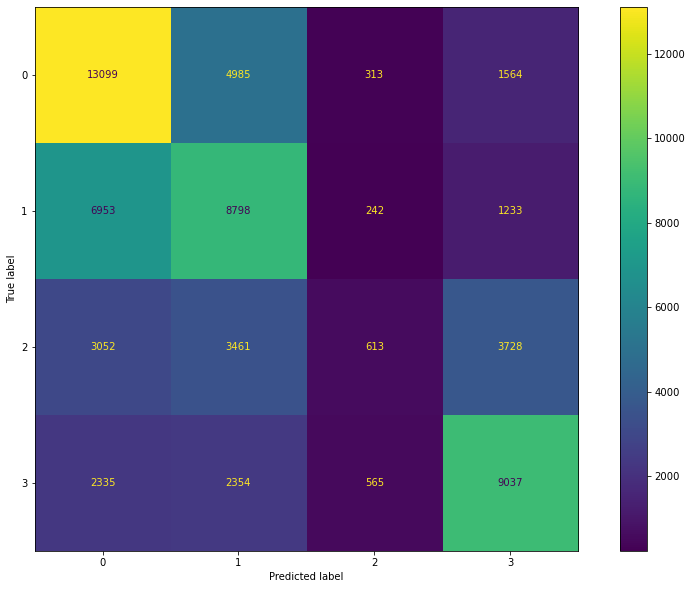

In [124]:
plot_confusion_matrix(estimator=tuned_xgb, X=X_test_new, y_true=y_test);

In [114]:
pd.DataFrame({'feature_importance': tuned_xgb.feature_importances_, 
              'feature_names': X_train_new.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
61,0.425654,Visitors with Patient_more
27,0.057093,Ward_Type_S
57,0.038220,Type of Admission_Trauma
59,0.031338,Severity of Illness_Minor
25,0.026349,Ward_Type_Q
...,...,...
51,0.002454,City_Code_Patient_20.0
50,0.002365,City_Code_Patient_19.0
54,0.002281,City_Code_Patient_25.0
48,0.002156,City_Code_Patient_16.0


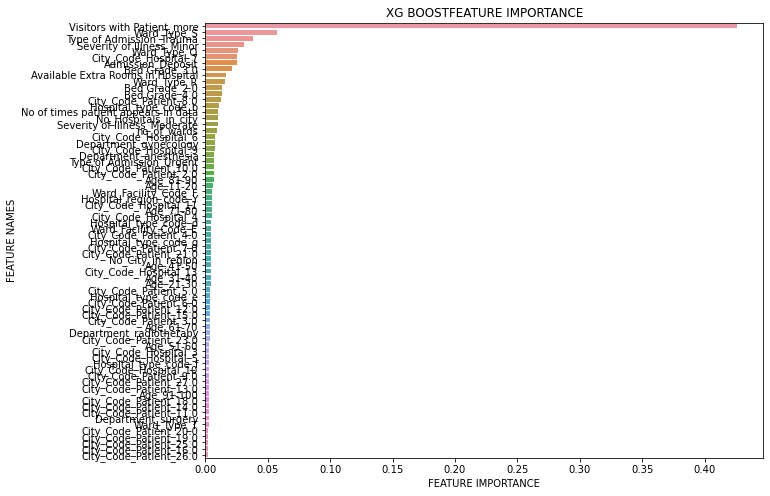

In [115]:
#plot the xgboost result
plot_feature_importance(tuned_xgb.feature_importances_,X_train_new.columns,'XG BOOST')


## Neural Network

In [116]:
import tensorflow as tf 
from tensorflow import keras

In [117]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200,activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(200,activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(4,activation = tf.nn.softmax))

In [118]:

model.compile(optimizer = tf.optimizers.Adam(),
       loss = 'sparse_categorical_crossentropy',
       metrics=['accuracy'])

In [119]:
model.fit(X_train_new,y_train, epochs = 80)

Epoch 1/80
7792/7792 [==============================] - 12s 1ms/step - loss: 1.1970 - accuracy: 0.4923
Epoch 2/80
7792/7792 [==============================] - 12s 1ms/step - loss: 1.1396 - accuracy: 0.5042
Epoch 3/80
7792/7792 [==============================] - 11s 1ms/step - loss: 1.1321 - accuracy: 0.5074
Epoch 4/80
7792/7792 [==============================] - 11s 1ms/step - loss: 1.1275 - accuracy: 0.5086
Epoch 5/80
7792/7792 [==============================] - 11s 1ms/step - loss: 1.1249 - accuracy: 0.5102 0s - loss: 1.1251 - 
Epoch 6/80
7792/7792 [==============================] - 11s 1ms/step - loss: 1.1229 - accuracy: 0.5110
Epoch 7/80
7792/7792 [==============================] - 11s 1ms/step - loss: 1.1216 - accuracy: 0.5115
Epoch 8/80
7792/7792 [==============================] - 10s 1ms/step - loss: 1.1203 - accuracy: 0.5118
Epoch 9/80
7792/7792 [==============================] - 11s 1ms/step - loss: 1.1189 - accuracy: 0.5130
Epoch 10/80
7792/7792 [=============================

In [120]:
val_loss,val_acc = model.evaluate(X_train_new,y_train)
print("Loss % = {} , Accuracy % = {} ".format(val_loss*100,val_acc*100))

7792/7792 [==============================] - 8s 1ms/step - loss: 1.0894 - accuracy: 0.5285
Loss % = 108.94327163696289 , Accuracy % = 52.85109877586365 


In [121]:
val_loss,val_acc = model.evaluate(X_test_new,y_test)
print("Loss % = {} , Accuracy % = {} ".format(val_loss*100,val_acc*100))

1948/1948 [==============================] - 2s 958us/step - loss: 1.1252 - accuracy: 0.5070
Loss % = 112.51885890960693 , Accuracy % = 50.70429444313049 


## Saving model and data for future use

In [122]:
pickle.dump(patientid_dict, open("patientid_dict.pkl", 'wb', pickle.HIGHEST_PROTOCOL))
pickle.dump(No_Hospitals_in_city_dict, open("No_Hospitals_in_city_dict.pkl", 'wb', pickle.HIGHEST_PROTOCOL))
pickle.dump(No_City_in_region_dict, open("No_City_in_region_dict.pkl", 'wb', pickle.HIGHEST_PROTOCOL))
pickle.dump(no_of_wards_dict, open("no_of_wards_dict.pkl", 'wb', pickle.HIGHEST_PROTOCOL))

In [123]:
a = np.zeros(shape=(1,91))
a = pd.DataFrame(a,columns=X_unscaled.columns)
pickle.dump(a, open("X_train_columns.pkl", 'wb', pickle.HIGHEST_PROTOCOL))
pickle.dump(ss_model, open("standardscalar.pkl", 'wb', pickle.HIGHEST_PROTOCOL))
pickle.dump(pipe, open("pipe.pkl", 'wb', pickle.HIGHEST_PROTOCOL))
pickle.dump(tuned_model, open("tuned_model.pkl", 'wb', pickle.HIGHEST_PROTOCOL))

In [125]:
accuracy_scores

[0.4897805300648142,
 0.4837483154719887,
 0.3929281909773471,
 0.4161586344092922,
 0.5145029840210485,
 0.5134601809664378,
 0.5107809792722839]

In [139]:
data = {'Accuracy_without_feature_engineering' : [0.42, 0.42, 0.35, 0.36, 0.47, 0.47, 0.47, np.nan],
        'Accuracy_with_feature_engineering' : [0.48, 0.48, 0.39, 0.41, 0.50, 0.50, 0.50, 0.51]}

In [140]:
key= ['LogisticRegression', 'RandomForsetClassifier', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'CatBoostClassifier', 'XGBClassifier', 'LGBMClassifier', '3-layer NN']

In [141]:
result = pd.DataFrame(data, index=key)

In [142]:
result

,Accuracy_without_feature_engineering,Accuracy_with_feature_engineering
LogisticRegression,0.42,0.48
RandomForsetClassifier,0.42,0.48
DecisionTreeClassifier,0.35,0.39
KNeighborsClassifier,0.36,0.41
CatBoostClassifier,0.47,0.50
XGBClassifier,0.47,0.50
LGBMClassifier,0.47,0.50
3-layer NN,NaN,0.51
